# Analysis of Travel Dataset: Guide to India's Must See Places

## Imports

In [98]:
#Import libarys
import pandas as pd
import math
import pingouin as pg
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy as sp
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import plotly.express as px
import plotly
import plotly.graph_objects as go
from plotly.graph_objs import Scatter, Figure, Histogram, Layout, Bar
plotly.offline.init_notebook_mode(connected = True)
from plotly.subplots import make_subplots
from geopy.geocoders import Nominatim
from pypalettes import load_cmap
from pypalettes import get_hex
from geopy.distance import geodesic

## Introduction

This dataset was downloaded from [Kaggle](https://www.kaggle.com/datasets/saketk511/travel-dataset-guide-to-indias-must-see-places).

The data is loaded into the noteboook, and the head and shape is displayed for initial inspection.

Through the process of the following inspection, it is found that the dataset is completely without NaN values. The na_filter is set to False to avoid filtering string of 'None' in the variable that describes what day an attraction is not open.

In [74]:
#File renamed to 'data.csv' and saved in current working directory
with open('data.csv') as x:
    ncols = len(x.readline().split(','))

df_raw = pd.read_csv('data.csv', usecols=range(1,ncols), na_filter = False)

In [76]:
#Make a copy of the dataset to avoid the need to re-import
df = df_raw.copy()

In [78]:
#display dataframe head for initial inspection
df.head()

Zone  State   City                  Name          Type  \
0  Northern  Delhi  Delhi            India Gate  War Memorial   
1  Northern  Delhi  Delhi        Humayun's Tomb          Tomb   
2  Northern  Delhi  Delhi     Akshardham Temple        Temple   
3  Northern  Delhi  Delhi  Waste to Wonder Park    Theme Park   
4  Northern  Delhi  Delhi         Jantar Mantar   Observatory   

  Establishment Year  time needed to visit in hrs  Google review rating  \
0               1921                          0.5                   4.6   
1               1572                          2.0                   4.5   
2               2005                          5.0                   4.6   
3               2019                          2.0                   4.1   
4               1724                          2.0                   4.2   

   Entrance Fee in INR Airport with 50km Radius Weekly Off   Significance  \
0                    0                      Yes       None     Historical   
1                   30                      Yes       None     Historical   
2                   60                      Yes       None      Religious   
3                   50                      Yes     Monday  Environmental   
4                   15                      Yes       None     Scientific   

  DSLR Allowed  Number of google review in lakhs Best Time to visit  
0          Yes                              2.60            Evening  
1          Yes                              0.40          Afternoon  
2           No                              0.40          Afternoon  
3          Yes                              0.27            Evening  
4          Yes                              0.31            Morning

In [80]:
# Dataset shape
print(df.shape)
 
rows, columns = df.shape
print(f"The dataset comprises {rows} properties described across {columns} attributes.")

(325, 15)
The dataset comprises 325 properties described across 15 attributes.




<ul>
    <li>Data types are analysed to shape analysis approach.

In [10]:
#Determine the data type for each feature
data_types = df.dtypes
 
# View a few datatypes from the dataset
print(data_types)

Zone                                 object
State                                object
City                                 object
Name                                 object
Type                                 object
Establishment Year                   object
time needed to visit in hrs         float64
Google review rating                float64
Entrance Fee in INR                   int64
Airport with 50km Radius             object
Weekly Off                           object
Significance                         object
DSLR Allowed                         object
Number of google review in lakhs    float64
Best Time to visit                   object
dtype: object


<ul>
    <li>
        Note that 'Establishment Year' is object, which is string type. This will need to be coverted to numerical for analysis.
    </li>

In [12]:
# Tally the total by data type
type_counts = data_types.value_counts()
 
print(type_counts)

object     11
float64     3
int64       1
Name: count, dtype: int64


<ul>
    <li>Visualizing the Missing Values

In [14]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

# Combining the counts and percentages into a DataFrame for better visualization
missing_info = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})

# Sorting the DataFrame by the percentage of missing values in descending order
missing_info = missing_info.sort_values(by='Percentage', ascending=False)

# Display columns with missing values
print(missing_info[missing_info['Missing Values'] > 0])

Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


<ul>
    <li>The dataset has no missing values. 

In [16]:
# Check the structure of the dataset
print("\nStructure of the dataset:")
print(df.info())


Structure of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Zone                              325 non-null    object 
 1   State                             325 non-null    object 
 2   City                              325 non-null    object 
 3   Name                              325 non-null    object 
 4   Type                              325 non-null    object 
 5   Establishment Year                325 non-null    object 
 6   time needed to visit in hrs       325 non-null    float64
 7   Google review rating              325 non-null    float64
 8   Entrance Fee in INR               325 non-null    int64  
 9   Airport with 50km Radius          325 non-null    object 
 10  Weekly Off                        325 non-null    object 
 11  Significance                      325 non-nu

## Clean-up and transformations
Modify the dataframe to simplify and improve the data analysis approach.

In [82]:
# Convert column names to lowercase
df.columns = df.columns.str.lower()

#rename columns to make them easier to work with
df = df.rename(columns = {'establishment year':'year', 'time needed to visit in hrs':'time', 'google review rating':'rating',
                         'entrance fee in inr':'fee', 'airport with 50km radius':'airport', 'weekly off':'off',
                         'dslr allowed':'camera', 'number of google review in lakhs':'reviews', 'best time to visit':'visit'})

# convert Binary variables to numerical
df['camera_num'] = df['camera'].astype('category').cat.codes

df['airport_num'] = df['airport'].astype('category').cat.codes

# create binary column for 'visit' == 'Anytime'
df['anytime'] = pd.get_dummies(df['visit'])['Anytime']#.astype(int)

# Convert 'Establishment Year' to numeric based on conditions
df['year_num'] = df['year'].apply(lambda x: int(re.findall('[0-9-]+', x)[0]) * 100 if re.search("century", x) else (
    int(re.findall('[0-9-]+', x)[0])) if re.findall('[0-9-]+', x) != [] else np.nan)

# Clean visit variable category types
df['visit'] = df['visit'].str.strip().replace('All','Anytime').astype('category')

# Convert all elements in the 'city' column to Cap Case
df['city'] = df['city'].str.title()

In [84]:
df.shape

(325, 19)

## Feature Engineering
Additional numerical variables are created based on the existing variables.

'ratings' is normalized and log-scale columns are created for skewed variables.

In [86]:
#Add column for time periods
df['year_group'] = df['year_num'].apply(lambda x: 'Prehistoric' if x <= -3300 else (
    'Bronze Age' if x <= -1800 else ('Iron Age' if x <= -200 else (
        'Classical Period' if x <= 650 else ('Early Medieval Period' if x <= 1200 else (
        'Late Medieval Period' if x <= 1526 else ('Early Medieval Period' if x <= 1858 else(
            'Late Modern and Contemporary Period' if x <= 1947 else (
            'Independence and Partition' if x > 1947 else 'Unknown'
            )))))))))

#Create column for ratio of fee to time ("Value")
df['cost_ratio'] = df['fee'] / df['time']

#Normalize ratings column
scaler = StandardScaler()
df['rating_norm'] = scaler.fit_transform(df[['rating']])

#log scale skewed variables
df['fee_log'] = np.log1p(df['fee'])

df['reviews_log'] = np.log1p(df['reviews'])

df['cost_ratio_log'] = np.log1p(df['cost_ratio'])

In [224]:
df['city'].unique().shape

(213,)

In [232]:
df['city'].unique()[211:213]

array(['Bengaluru', 'Cherrapunji'], dtype=object)

In [254]:

geolocator = Nominatim(user_agent="my_geocoder")

location = geolocator.geocode("Agra")

location.latitude

    # if location:
    #     clat.append(location.latitude)
    #     clon.append(location.longitude)
    #     cities.append(city)
    # else:
    #     clat.append(np.nan)
    #     clon.append(np.nan)
    #     cities.append(city)

27.1752554

In [256]:
#Create empty lists to store geolocation data
clat = []
clon = []
cities = []

#Geolocation tool
geolocator = Nominatim(user_agent="my_geocoder")

#Create latitude and longitude lists for each city
for city in df['city'].unique()[0:10]:
    
    location = geolocator.geocode(city)

    if location:
        clat.append(location.latitude)
        clon.append(location.longitude)
        cities.append(city)
    else:
        clat.append(np.nan)
        clon.append(np.nan)
        cities.append(city)

In [372]:
#Create latitude and longitude lists for each city
for city in df['city'].unique()[210:213]:
    
    location = geolocator.geocode(city)

    if location:
        clat.append(location.latitude)
        clon.append(location.longitude)
        cities.append(city)
    else:
        clat.append(np.nan)
        clon.append(np.nan)
        cities.append(city)

In [374]:
len(cities)

213

In [186]:
#Create latitude and longitude lists for each city
for city in df['city'].unique()[200:213]:
    
    location = geolocator.geocode(city)

    if location:
        clat.append(location.latitude)
        clon.append(location.longitude)
        cities.append(city)
    else:
        clat.append(np.nan)
        clon.append(np.nan)
        cities.append(city)

In [100]:
#Create empty lists to store geolocation data
clat = []
clon = []
cities = []

#Geolocation tool
geolocator = Nominatim(user_agent="my_geocoder")

#Create latitude and longitude lists for each city
for city in df['city'].unique():
    
    location = geolocator.geocode(city)

    if location:
        clat.append(location.latitude)
        clon.append(location.longitude)
        cities.append(city)
    else:
        clat.append(np.nan)
        clon.append(np.nan)
        cities.append(city)

GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Puri&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))

In [376]:
#Combine lists into dataframe
cgeo = pd.DataFrame({'city':cities, 'lat':clat, 'lon':clon}).set_index('city')

#Manually update locations that Nominatim did not locate correctly
cgeo.loc['Dalhousie'] = [32.53, 75.98]
cgeo.loc['Auli'] = [30.52892, 79.57026]
cgeo.loc['Manas'] = [26.716667, 90.933333]
cgeo.loc['Barot'] = [32.036389, 76.8475]
cgeo.loc['Shoja'] = [31.5672, 77.3705]
cgeo.loc['Aurangabad'] = [19.88, 75.32]
cgeo.loc['Mandu'] = [22.335278, 75.415833]
cgeo.loc['Bandipur'] = [11.661667, 76.627222]

#Create new dataframe by merging the original dataframe with the geolocation data
df_geo = pd.merge(df,cgeo, on = 'city')

In [384]:
cgeo

# Export the dataframe to a CSV file
cgeo.to_csv('cgeo.csv', index=False)

## Descriptive Statistics

Sanity check on descriptive statistics

In [ ]:
# Descriptive statistics for numerical columns
print(df.describe())

## Univariate Analyiss

Proceeding with univariate analysis

In [ ]:
def univariate(x, df=df, outliers = 'yes'):
    """
    Display univariate information for numerical variables.
    
    Parameters
    ----------
    x : string
        The name of the numerical variable for analyis
    df : dataframe, optional
        The dataframe to analyze, default value = df
    outliers : string, optional
        'yes' to display outliers, 'no' to filter them, default value = 'yes'
    
    Returns
    -------
    Dataframe sorted by x column, largest values
    
    Dataframe sorted by x column, smallest values
    
    histogram of x with boxplot above
    
    """
    #display dataframe sorted by x column, largest values
    display(df.sort_values(x, ascending = False).head())

    #display dataframe sorted by x column, smallest values. If all values are 0, do not display
    if df.sort_values(x, ascending = True).head()[x].sum() > 0:
        display(df.sort_values(x, ascending = True).head())

    #filter outliers if enabled
    if outliers == 'no':
        df = df.loc[df[[x]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

    #display histogram of x variable
    fig = px.histogram(df, x=x, title = 'Histogram of ' + x, nbins = int(len(df) ** (1 / 2)), marginal = 'box', hover_name = 'name')
    fig.show()

In [ ]:
univariate('rating_norm')

## Correlation Analysis

In [448]:
def corr_matrix(x = None, y = None, df=df):
    """
    Display correlation dataframe for numerical variables.
    
    Parameters
    ----------
    x : string, optional
        The name of the categorical variable for filter, default value = None
    y : string, optional
        The name of the categorical element for filter, default value = None
    df : dataframe, optional
        The dataframe to analyze, default value = df
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.3
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    
    Returns
    -------
    Correlation table
    
    """

    #Apply correlation matrix to entire dataframe, unless x and y variables are provided for filter
    if x == None:
        df = df
    else:
        df = df[df[x] == y]

    #Set plot size
    plt.figure(figsize=(10,8))

    #Create correlation matrix
    corr_matrix = df.corr(numeric_only = True)

    #Convert correlation matrix to heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

    #Set correlation matrix title
    plt.title('Correlation Matrix')

    #display correlation matrix
    plt.show()

def corr_table(x = None, y = None, df=df, t_min = 0.3, t_max = 1):
    """
    Display correlation dataframe for numerical variables.
    
    Parameters
    ----------
    x : string, optional
        The name of the categorical variable for filter, default value = None
    y : string, optional
        The name of the categorical element for filter, default value = None
    df : dataframe, optional
        The dataframe to analyze, default value = df
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.3
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    
    Returns
    -------
    Correlation table
    
    """
    #Apply correlation matrix to entire dataframe, unless x and y variables are provided for filter
    
    
    if x == None:
        df = df
    else:
        df = df[df[x] == y]

    #Create correlation matrix
    corr = df.corr(numeric_only = True)

    #convert correlation matrix into list of lists
    result = []
    for row in corr.index:
        for col in corr:
            if row != col:
                result.append([row, col, corr[col][row]])
    
    #convert list into dataframe
    corr_df = pd.DataFrame(result, columns = ['var_1','var_2','corr'])

    #Sort dataframe on correlation
    corr_df = corr_df.sort_values('corr', ascending = False)
    
    #Filter variables that are directly correlated 
    corr_df = corr_df[~(corr_df['var_1'].str.contains('rating') & corr_df['var_2'].str.contains('rating'))]
    corr_df = corr_df[~(corr_df['var_1'].str.contains('cost|fee') & corr_df['var_2'].str.contains('cost|fee'))]
    corr_df = corr_df[~(corr_df['var_1'].str.contains('reviews') & corr_df['var_2'].str.contains('reviews'))]

    #Filter duplicate rows
    #corr_df = corr_df.iloc[::2]

    #Filter by minimum and maximum correlation threshold
    corr_df = corr_df[(abs(corr_df['corr']) > t_min) & (abs(corr_df['corr']) <= t_max)]

    #Add columns for category and type
    corr_df['category'] = x
    corr_df['type'] = y

    return corr_df


def corr_info(x = None, y = None, df = df, t_min = 0.3, t_max = 1):
    """
    Display correlation matrix and dataframe for numerical variables.
    
    Parameters
    ----------
    x : string, optional
        The name of the categorical variable for filter, default value = None
    y : string, optional
        The name of the categorical element for filter, default value = None
    df : dataframe, optional
        The dataframe to analyze, default value = df
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.3
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    
    Returns
    -------
    Correlation matrix with heatmap
    
    Correlation table
    
    """
    #Display correlation matrix
    corr_matrix(x, y, df)

    #Display correlation table
    display(corr_table(x, y, df, t_min, t_max))

def corr_cat(x, t_min=0.3, t_max = 1, df=df, f = 3):
    """
    Combine correlation tables across a single variable.
    
    Parameters
    ----------
    x : string, optional
        The name of the categorical variable for filter, default value = None
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.3
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    df : dataframe, optional
        The dataframe to analyze, default value = df
    f : int, optional
        Count of elements by which to filter, default value = 3
    
    Returns
    -------
    
    Combined correlation table
    
    """
    #Create empty dataframe
    corr_cat_df = pd.DataFrame()

    #Filter grouped dataframe by element count
    df = df.groupby(x, observed = False).filter(lambda x: len(x) > f)

    #Loop through types within category, combine dataframes
    for y in df[x].unique():
        temp_df = corr_table(x, y, t_min=t_min, t_max=t_max, df=df)
        corr_cat_df = pd.concat([corr_cat_df, temp_df], axis = 0)

    #Return combined dataframe
    return corr_cat_df

def corr_total(t_min = 0.9, t_max = 1, f = 10, df=df):
    """
    Combine correlation tables across all variables.
    
    Parameters
    ----------
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.9
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    f : int, optional
        Count of elements by which to filter, default value = 10
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Combined correlation table
    
    """
    #Create empty dataframe
    corr_total_df = pd.DataFrame()

    #Loop through variables within dataframe, combine dataframes
    for x in df.loc[:, df.columns != 'year'].select_dtypes(exclude='number').columns:
        temp_df = corr_cat(x, t_min=t_min, t_max=t_max, f = f, df=df)
        corr_total_df = pd.concat([corr_total_df, temp_df], axis = 0)

    #Sort dataframe on correlation
    corr_total_df = corr_total_df.sort_values('corr', ascending = False)

    #Return combined dataframe
    return corr_total_df


def corr_total_f(t_min = 0.9, t_max = 1, f = 10, df=df):
    """
    Filter unnecessary features from corr_total.
    
    Parameters
    ----------
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.9
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    f : int, optional
        Count of elements by which to filter, default value = 10
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Combined correlation table
    
    """
    
    #Remove unnecessary features
    temp_df = df.drop(['anytime', 'camera_num', 'airport_num'], axis = 1)

    #Create correlation table
    temp_df = corr_total(t_min = t_min, t_max = t_max, f = f, df=temp_df)

    #filter out year_num from var_2 column
    temp_df = temp_df[temp_df['var_2'] != 'year_num']


    return temp_df

In [ ]:
corr_info()

In [ ]:
corr_info(df=df[df['year_num'] > 1400])

In [ ]:
corr_total(df=df.drop(['rating_norm', 'reviews', 'fee', 'cost_ratio', 'camera_num', 'airport_num'], axis = 1), t_min = .6, f = 20)

In [ ]:
x = None
y = None
sns.set_theme(style="white")
cmap = load_cmap('Balistapus_undulatus', type='continuous', type_warning = False)

temp_df = df.drop(['rating_norm', 'reviews_log', 'fee_log', 'cost_ratio_log'], axis = 1)
temp_df = df[['time','fee','rating','camera_num','year_num']]

#Set plot size
plt.figure(figsize=(8,6))

#Create correlation matrix
corr_matrix_df = temp_df.corr(numeric_only = True)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix_df)
mask[np.triu_indices_from(mask)] = True

#Convert correlation matrix to heatmap
sns.heatmap(corr_matrix_df, annot=True, cmap=cmap, mask=mask, annot_kws = {'size': 20}, center = 0)

#Set correlation matrix title
plt.title('Correlation Matrix')

#display correlation matrix
plt.show()

## Bivariate Analysis

In [452]:
def bivar_box(x, y, df=df, text='name', cat=None):
    """
    Display boxplots for discrete numerical categories.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the categorical element for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    text : string, optional
        The hover name value for outlier points, default value = 'name'
    cat : string, optional
        Category by which to color code data, default value = None
    
    Returns
    -------
    
    Box plots for each discrete number category.
    
    """
    #filter outliers
    temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

    #create figure
    fig = px.box(temp_df, x=x, y=y, hover_name=text, color = cat, title = y + " vs " + x)

    return fig

def outliers(x, y, df=df):
    """
    Create dataframe of outliers based on category and type.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the categorical element for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Dataframe of outliers.
    
    """

    #create outliers dataframe, remove NaNs
    outliers_df = df[[x, y]].dropna()

    #filter outliers from dataframe
    outliers_df = outliers_df.loc[~outliers_df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

    #merge filtered dataframe onto original dataframe
    outliers_df = outliers_df.merge(df, how = 'left', left_index = True, right_index = True, 
                              suffixes = ['', '_y'])[['name', x, y]].sort_values(by = y)
    
    return outliers_df

def bivar_sca(x, y, df=df, text = 'name', cat = None):
    """
    Display scatter plot for numerical categories.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the categorical element for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    text : string, optional
        The hover name value for points, default value = 'name'
    cat : string, optional
        Category by which to color code data, default value = None
    
    Returns
    -------
    
    Scatter plot for numerical category.
    
    """
    #filter outliers
    temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

    #create figure
    fig = px.scatter(temp_df, x=x, y=y, color = cat, hover_name=text, title = y + " vs " + x)

    return fig


def bivariate(x, y, df=df, text = 'name', cat = None, type = 'sca'):
    """
    Display plot for numerical categories.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the categorical element for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    text : string, optional
        The hover name value for points, default value = 'name'
    cat : string, optional
        Category by which to color code data, default value = None
    type : string, optional
        Type of plot to produce, default value = 'sca'
        Produce scatter plot : type = 'sca'
        Produce box plot : type = 'box'
    
    Returns
    -------
    
    Plot and outliers table.
    
    """

    #Display either scatter or box plot, depending on value of 'type'
    if type == 'sca':
        bivar_sca(x, y, df, text, cat).show()
    elif type == 'box':
        bivar_box(x, y, df, text, cat).show()
    #return outliers dataframe
    return display(outliers(x, y))
    


In [ ]:
bivariate('rating_norm', 'fee')

In [ ]:
bivariate('time', 'fee_log', type='box')

In [ ]:
bivariate('year_num', 'rating_norm', cat = 'camera')

In [ ]:
#create filtered correlation table
temp_df = corr_total_f()

#Create scatter plot for each combination of variables in correlation table
for loc in range(0, len(temp_df)):
    var_1, var_2, corr, category, type = temp_df.iloc[loc]
    print(category)
    print(type)
    print(loc)
    display(bivar_sca(var_1, var_2, df = df[df[category] == type]))

Categorical analysis

## Categorical Analysis

In [ ]:
def cat_hist(x, df=df):
    """
    Create bar chart showing count of each type within variable x.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Bar chart of count.
    
    """
    #filter dataframe on elements with count greater than 3
    temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3)

    #create figure
    fig = px.histogram(temp_df, x=x).update_xaxes(categoryorder="total descending")

    return fig


def cat_bar(x, y, df=df):
    """
    Create bar chart showing average value of each type y within variable x.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the numerical element for bar value.
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Bar chart of average y-value.
    
    """
    #filter dataframe on elements with count greater than 3. Compute mean y value of each type.
    temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    x, observed = False)[[y]].mean().sort_values(y, ascending = False).dropna()

    #create figure
    fig = px.bar(temp_df, y=y)

    #plot settings
    fig.update_layout(
        title="Average rating for each "+ x + " category",
        xaxis_title="",
        yaxis_title=y,)

    return fig        


def categorical(x, y, df=df):
    """
    Produce bar chart of counts.
    Produce bar chart of average y value.
    Display ANOVA stats
    Display t-test dataframe.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y ; string
        The name of the numerical element to compute tests.
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Bar chart of counts.
    Bar chart of average y value.
    ANOVA stats
    t-test dataframe
    
    """

    cat_hist(x, df=df).show()
    
    cat_bar(x, y, df=df).show()
    
    print(pg.anova(data=df, dv=y, between=x))

In [ ]:
x = 'type'
y= 'cost_ratio'

#filter dataframe on elements with count greater than 3. Compute mean y value of each type.
temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
x, observed = False)[[y]].median().sort_values(y, ascending = False).dropna()

#create figure
fig = px.bar(temp_df, y=y)

#plot settings
fig.update_layout(
    title="Average rating for each "+ x + " category",
    xaxis_title="",
    yaxis_title=y,)

fig.show()

In [ ]:
x = 'significance'
y= 'cost_ratio'

#filter dataframe on elements with count greater than 3. Compute mean y value of each type.
temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
x, observed = False)[[y]].median().sort_values(y, ascending = False).dropna()

#create figure
fig = px.bar(temp_df, y=y)

#plot settings
fig.update_layout(
    title="Average rating for each "+ x + " category",
    xaxis_title="",
    yaxis_title=y,)

fig.show()

In [ ]:
categorical('year_group', 'rating_norm')

In [ ]:
categorical('significance', 'rating_norm')

In [ ]:
categorical('significance', 'cost_ratio')

In [ ]:
categorical('type', 'fee')

In [ ]:
categorical('city', 'fee')

In [ ]:
categorical('state', 'rating_norm')

In [ ]:
categorical('zone', 'fee')

## Geo Spatial

In [386]:
def filter_locations(df, center_lat, center_lon, max_distance):
    """
    Filters a dataframe based on distance from a center point.
    
    Parameters
    ----------
    df : dataframe
        The dataframe containing latitude and longitude columns.
    center_lat: float
        Latitude of the center point.
    center_lon: float
        Longitude of the center point.
    max_distance: int
        Maximum distance in kilometers.
    
    Returns
    -------
    
    Filtered dataframe.
    """

    def calculate_distance(row):
        coords_1 = (center_lat, center_lon)
        coords_2 = (row['lat'], row['lon'])
        return geodesic(coords_1, coords_2).km

    df['distance'] = df.apply(calculate_distance, axis=1)
    return df[df['distance'] <= max_distance]

In [388]:
def calculate_circumcenter(x1, y1, x2, y2, x3, y3):
    """
    Calculates the circumcenter of a triangle formed by three points.
    The circumcenter is the point that is equidistant from all three vertices.
    
    Parameters
    ----------
    x1 : float
        x-coordinate of first point.
    y1 : float
        y-coordinate of first point.
    x2 : float
        x-coordinate of second point.
    y2 : float
        y-coordinate of second point.
    x3 : float
        x-coordinate of third point.
    y3 : float
        y-coordinate of third point.

    
    Returns
    -------
    
    Circumcenter x and y
    """

    # Calculate the midpoints of two sides of the triangle
    midpoint1_x = (x1 + x2) / 2
    midpoint1_y = (y1 + y2) / 2
    midpoint2_x = (x2 + x3) / 2
    midpoint2_y = (y2 + y3) / 2

    # Calculate the slopes of the two sides
    slope1 = (y2 - y1) / (x2 - x1) if x2 != x1 else float('inf')
    slope2 = (y3 - y2) / (x3 - x2) if x3 != x2 else float('inf')

    # Calculate the perpendicular bisector slopes
    perp_slope1 = -1 / slope1 if slope1 != 0 else float('inf')
    perp_slope2 = -1 / slope2 if slope2 != 0 else float('inf')

    # Calculate the intersection of the perpendicular bisectors, which is the circumcenter
    if perp_slope1 == float('inf'):
        circumcenter_x = midpoint1_x
        circumcenter_y = perp_slope2 * (circumcenter_x - midpoint2_x) + midpoint2_y
    elif perp_slope2 == float('inf'):
        circumcenter_x = midpoint2_x
        circumcenter_y = perp_slope1 * (circumcenter_x - midpoint1_x) + midpoint1_y
    else:
        circumcenter_x = (midpoint2_y - midpoint1_y + perp_slope1 * midpoint1_x - perp_slope2 * midpoint2_x) / (perp_slope1 - perp_slope2)
        circumcenter_y = perp_slope1 * (circumcenter_x - midpoint1_x) + midpoint1_y

    return circumcenter_x, circumcenter_y

In [390]:
def coord_grid(lat_min = df_geo['lat'].min(), lat_max = df_geo['lat'].max(),
               lon_min = df_geo['lon'].min(), lon_max = df_geo['lon'].max(), r = 150, df = df_geo):
    """
    Creates a coordinate grid from latitude and longitude minimum and maximum and spacing in kilometers.
    
    Parameters
    ----------
    lat_min : float, optional
        Minimum latitude, default value = df_geo['lat'].min()
    lat_max : float
        Maximum latitude, default value = df_geo['lat'].max()
    lon_min : float, optional
        Minimum longitude, default value = df_geo['lon'].min()
    lon_max : float, optional
        Maximum longitude, default value = df_geo['lon'].max()
    r : int, optional
        length of grid step, default value = 150
    df : dataframe, optional
        The dataframe containing latitude and longitude columns, default value = df_geo

    
    Returns
    -------
    
    Dataframe of grid coordinates.
    """
    
    r = r
    
    # Define the grid dimensions
    x_min, x_max = lat_min, lat_max
    y_min, y_max = lon_min, lon_max
    #convert kilometers to decimal coordinates
    step = 0.01 * r
    
    # Create the coordinate arrays
    x = np.arange(x_min, x_max + step, step)
    y = np.arange(y_min, y_max + step, step)
    
    # Create the meshgrid
    xx, yy = np.meshgrid(x, y)
    
    # Create the dataframe
    coord_grid_df = pd.DataFrame({'x': xx.ravel(), 'y': yy.ravel()})
    
    return coord_grid_df

In [392]:

def grid_info(lat_min = df_geo['lat'].min(), lat_max = df_geo['lat'].max(),
              lon_min = df_geo['lon'].min(), lon_max = df_geo['lon'].max(),
              r = 150, df = df_geo, z='rating_norm'):
    """
    Creates a dataframe of useful information for locations within r kilometers of each location in coordinate grid
    
    Parameters
    ----------
    lat_min : float, optional
        Minimum latitude, default value = df_geo['lat'].min()
    lat_max : float
        Maximum latitude, default value = df_geo['lat'].max()
    lon_min : float, optional
        Minimum longitude, default value = df_geo['lon'].min()
    lon_max : float, optional
        Maximum longitude, default value = df_geo['lon'].max()
    r : int, optional
        length of grid step, default value = 150
    df : dataframe, optional
        The dataframe containing latitude and longitude columns, default value = df_geo

    
    Returns
    -------
    
    Dataframe of grid information.
    """
    

    x_lst = []
    y_lst = []
    avg_lst = []
    ctp_lst = []
    ct_lst = []
    med_lst = []
    
    for i in range(0, coord_grid().shape[0]-1):
        
        temp_df = df[['city','lat','lon']].drop_duplicates().dropna()
        x, y = coord_grid().sort_values('x').iloc[i]
    
        temp_df = filter_locations(temp_df, x, y, r)
        
        temp_df = df[df['city'].isin(temp_df['city'])]
    
        temp_p_df = temp_df[temp_df[z] > 0]
        
        if not temp_df.empty:
            avg_lst.append(temp_df[z].mean())
            med_lst.append(temp_df[z].median())
            ctp_lst.append(temp_p_df[z].count())
            ct_lst.append(temp_df.shape[0])
            x_lst.append(x)
            y_lst.append(y)
    
    temp_df = pd.DataFrame({'lat':x_lst, 'lon':y_lst, 'total_count':ct_lst, 'pos_count':ctp_lst, 'mean':avg_lst, 'med':med_lst})
    
    return temp_df

In [480]:
def draw_circle(lat, lon, radius):
    # Calculate circle coordinates
    num_points = 360  # Number of points for the circle
    circle_lats, circle_lons = [], []
    for bearing in np.arange(0, 360, 360/num_points):
        circle_lats.append(lat + radius * np.cos(np.radians(bearing)) / 111.32)
        circle_lons.append(lon + radius * np.sin(np.radians(bearing)) / (111.32 * np.cos(np.radians(lat))))
    
    # Add circle to the map
    return fig.add_trace(go.Scattermapbox(
        lat=circle_lats,
        lon=circle_lons,
        mode="lines",
        line=dict(color="blue"),
        opacity=0.5,
        hoverinfo="none", showlegend = False
    ))

In [396]:
#Create dataframe from grid_info function
grid_info_df = grid_info()

In [512]:
#Create temporary dataframe from grid_info filtered on positive normalized ratings
temp_df = grid_info_df[grid_info_df['mean'] > 0].copy()

#Create 'dist' column for coordinate distance from origin
temp_df['dist'] = (temp_df['pos_count'] ** 2 + temp_df['mean'] ** 2) ** 0.5

#Store value of mean for point with largest distance from origin
avg_top = temp_df.sort_values('dist', ascending = False)['mean'].iloc[0]

#filter dataframe on mean ratings above previously calculated avg_top
temp_df = temp_df[temp_df['mean'] >= avg_top].sort_values('dist', ascending = False)

#Store the coordinates from the top two results of previous dataframe
lat1, lon1 = temp_df.head(2)[['lat','lon']].iloc[0]
lat2, lon2 = temp_df.head(2)[['lat','lon']].iloc[1]

#Create temporary dataframe with city, latitude and longitude
temp_df = df_geo[['city','lat','lon']].drop_duplicates().dropna()

# location filter radius in kilometers
filter_1 = filter_locations(temp_df, lat1, lon1, 150)['city']

# location filter radius in kilometers
filter_2 = filter_locations(temp_df, lat2, lon2, 150)['city']

# combine filters
filter = pd.concat([filter_1, filter_2]).drop_duplicates()

temp_df = df[df['city'].isin(filter)]

mean = temp_df['rating_norm'].mean()
print(f"The average is {mean}")

size = temp_df.shape[0]

pos = temp_df[temp_df['rating_norm']>0].shape[0]

abv_avg_pct = pos / size * 100

print(f"{abv_avg_pct}% have rating above average")


display(temp_df.groupby('significance').filter(lambda x: len(x) > 1).groupby(
    'significance')[['rating_norm']].mean().sort_values('rating_norm'))

north_top_df = temp_df.sort_values(['rating','reviews'],ascending = False).head()[['name']]

north_top_df = north_top_df.rename(columns={'name':'North'}).reset_index(drop=True)

display(north_top_df)

The average is 0.32407019610188015
75.0% have rating above average


rating_norm
significance             
Recreational    -0.861381
Wildlife        -0.496627
Nature          -0.168348
Adventure        0.597636
Religious        0.658428
Historical       0.780013

North
0  Golden Temple (Harmandir Sahib)
1                      Pangong Tso
2                 Jallianwala Bagh
3                     Wagah Border
4                Dras War Memorial

# Plots

## Slide 3

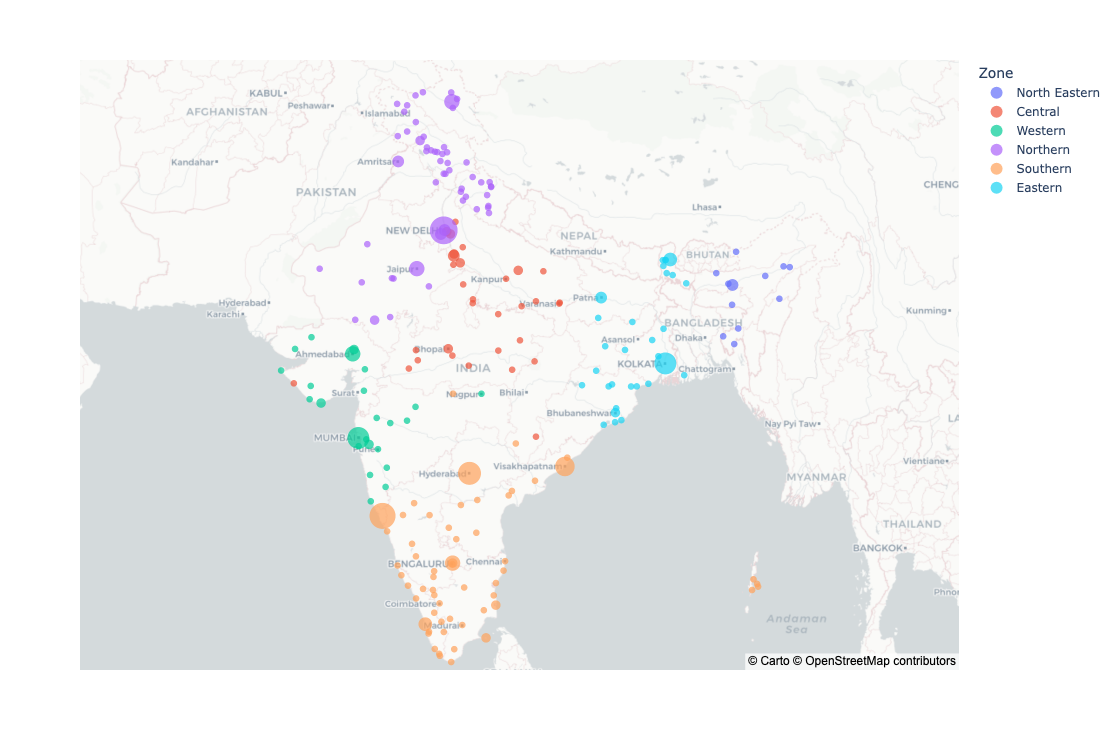

In [400]:
#Create temporary dataframe from geospacial dataframe
temp_df = df_geo.groupby(['city','zone','lat','lon']).count().reset_index(['city','zone','lat','lon']).copy()

# Create the map
fig = px.scatter_mapbox(temp_df, lat="lat", lon="lon", color="zone",
                        zoom=3.8, height=750, width=1000,
                        mapbox_style="carto-positron",center=dict(lat=22.5, lon=81), hover_name = 'city',size = 'state')


# Show the map
fig.update_layout(legend_title_text="Zone")
fig.show()

In [404]:
df_geo[df_geo['city'] == 'Porbandar']

zone          state       city          name      type  year  time  \
212  Central  Uttar Pradesh  Porbandar  Kirti Mandir  Memorial  1950   1.0   

     rating  fee airport  ... anytime year_num                  year_group  \
212     4.8    0     Yes  ...   False   1950.0  Independence and Partition   

     cost_ratio rating_norm  fee_log  reviews_log  cost_ratio_log      lat  \
212         0.0    1.144767      0.0     0.029559             0.0  21.6409   

        lon  
212  69.611  

[1 rows x 27 columns]

## Slide 4 & 5

In [406]:
u = df['rating'].unique().shape[0]
print(f'There are {u} unique ratings in the dataset')

a = df[df['rating'] == 4.8].shape[0]
print(f'There are {a} attractions with rating equal to 4.8')

There are 14 unique ratings in the dataset
There are 26 attractions with rating equal to 4.8


In [408]:
#Create sorted temporary dataframe
sorted_df = df.sort_values(by=['rating','reviews'], ascending = False).head(10).copy()

#Isolate specific columns
temp_df = sorted_df[['name','rating','reviews']]

#Rename columns
temp_df = temp_df.rename(columns={'name':'Name','rating':'Rating','reviews':'Reviews (x1,000)'})

#Create dataframe of top ten attractions
top_df = temp_df.reset_index(drop = True)

#Write dataframe to .csv for import to slides deck
top_df.to_csv('top.csv', index = False)

top_df

Name  Rating  Reviews (x1,000)
0  Golden Temple (Harmandir Sahib)     4.9              1.90
1                      Pangong Tso     4.9              0.15
2                       Rann Utsav     4.9              0.10
3                        Kedarnath     4.8              2.00
4        Mahakaleshwar Jyotirlinga     4.8              1.20
5             Siddhivinayak Temple     4.8              1.05
6           Gurudwara Bangla Sahib     4.8              1.05
7               Mahalakshmi Temple     4.8              0.90
8                      Prem Mandir     4.8              0.49
9                   Somnath Temple     4.8              0.39

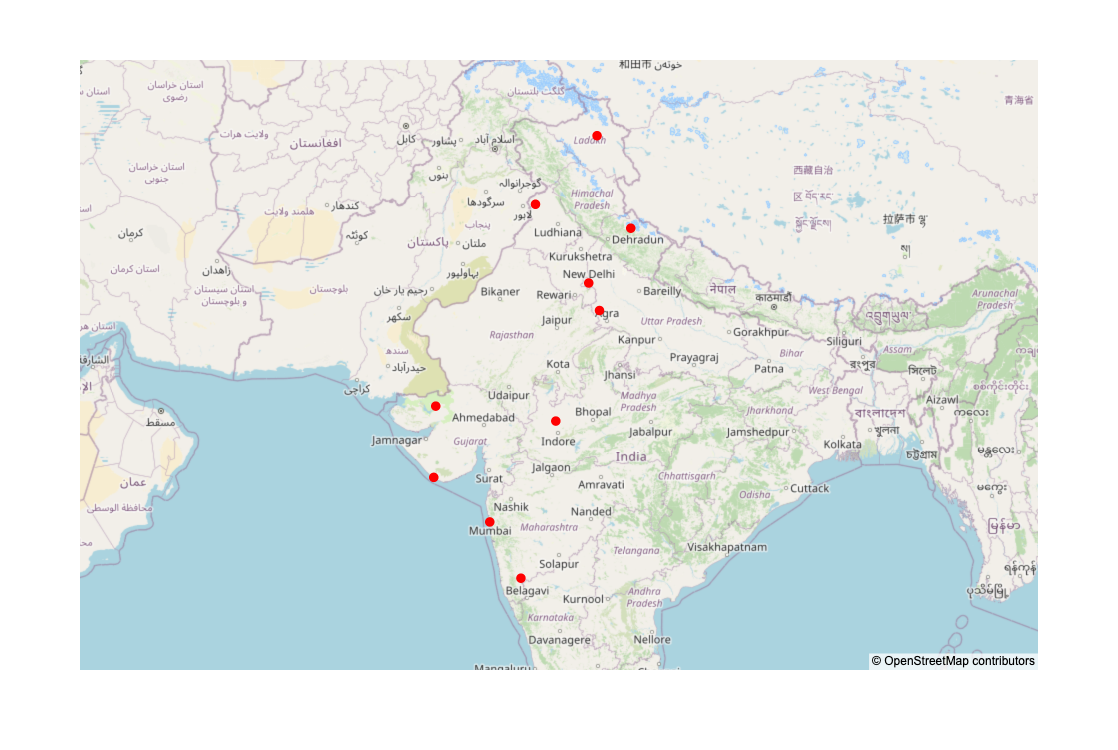

In [410]:
#Create sorted dataframe
temp_df = df_geo.sort_values(by=['rating','reviews'], ascending = False).head(10).copy()

#Extract coordinates of top and bottom city by latitude
x1, y1 = temp_df.sort_values('lat').head(1)[['lat','lon']].iloc[0]
x2, y2 = temp_df.sort_values('lat').tail(1)[['lat','lon']].iloc[0]

#calculate midpoint between top and bottom city
lat_mid = (x1 + x2)/2
lon_mid = (y1 + y2)/2

# Create a scatter mapbox plot
fig = px.scatter_mapbox(temp_df, lat="lat", lon="lon", hover_name="name",
                        zoom=4, center=dict(lat=lat_mid, lon=lon_mid), height=750, width=1000)

# Customize the map appearance
fig.update_layout(mapbox_style="open-street-map")
fig.update_traces(marker=dict(size=10, color="red"))

# Show the map
fig.show()

## Slide 7

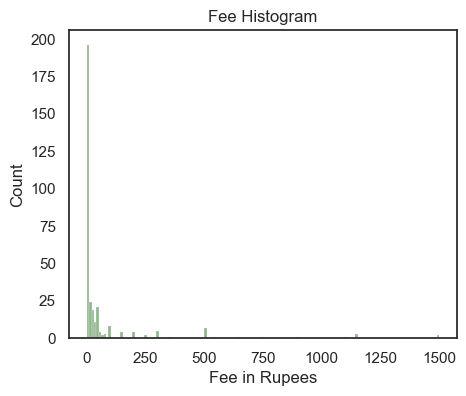

In [412]:
#Plot settings
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')
plt.figure(figsize=(5, 4))

#Create dataframe with 'fee' outliers removed
temp_df = df[df[['fee']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)].copy()

#Create histogram
sns.histplot(temp_df['fee'], fill=True, color=colors[2])

plt.title("Fee Histogram")
plt.xlabel("Fee in Rupees")

plt.show()

In [ ]:
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')
plt.figure(figsize=(5, 4))

temp_df = df.loc[df[['fee']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

temp_df = temp_df[temp_df['fee'] > 50]


sns.histplot(temp_df['fee'], fill=True, color=colors[2])

plt.title("Fee Histogram (Fee above 50 rupees)")
plt.xlabel("Fee in Rupees")
plt.show()

## Slide 8

In [ ]:
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')
plt.figure(figsize=(5, 4))

y='fee'

temp_df = df.loc[df[['time',y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
ax = sns.boxplot(x="time", y=y, data=temp_df, color = colors[1])

plt.title("Time Required vs. Fee")
plt.xlabel("Time Required (Hrs)")
plt.ylabel("Fee (Rupees)")

plt.show()

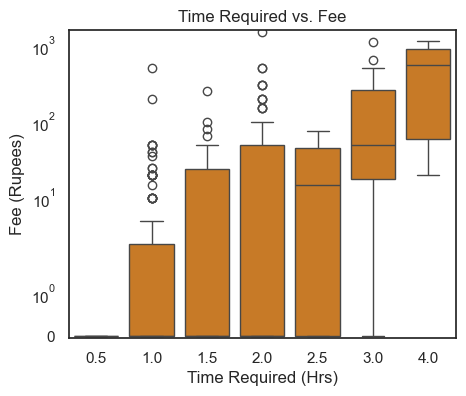

In [420]:
sns.set(rc={'figure.figsize':(5, 4)})
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')

y='fee'

temp_df = df.loc[df[['time',y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
ax = sns.boxplot(x="time", y=y, data=temp_df, color = colors[0])


ax.set_yscale('symlog')
plt.title("Time Required vs. Fee")
plt.xlabel("Time Required (Hrs)")
plt.ylabel("Fee (Rupees)")
plt.ylim(ymin=-.05) 

plt.show()

## Slide 10

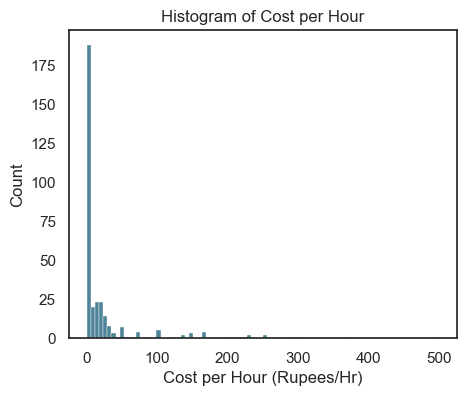

(280, 25)

In [422]:
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')
plt.figure(figsize=(5, 4))

temp_df = df.loc[df[['cost_ratio']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]


sns.histplot(temp_df['cost_ratio'], fill=True, color=colors[3])
plt.title("Histogram of Cost per Hour")
plt.xlabel("Cost per Hour (Rupees/Hr)")
plt.show()

temp_df[temp_df['cost_ratio'] < 50].shape

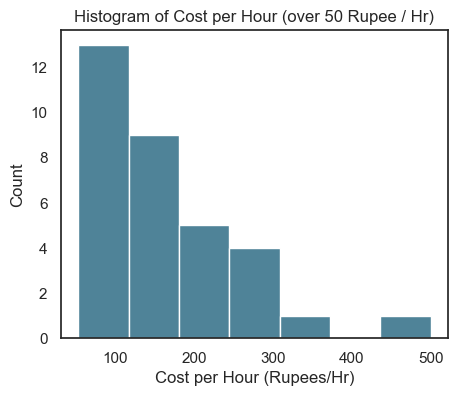

In [424]:
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')
plt.figure(figsize=(5, 4))

temp_df = df.loc[df[['cost_ratio']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

temp_df = temp_df[temp_df['cost_ratio'] > 50]


sns.histplot(temp_df['cost_ratio'], fill=True, color=colors[3])

plt.title("Histogram of Cost per Hour (over 50 Rupee / Hr)")
plt.xlabel("Cost per Hour (Rupees/Hr)")

plt.show()

## Slide 11

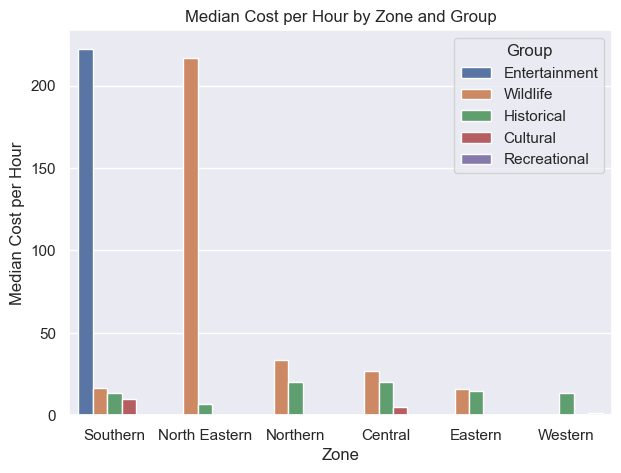

In [426]:
x= 'significance'
y = 'cost_ratio'

temp_df = df

temp_df = temp_df.groupby(['zone',x]).filter(lambda x: len(x) > 2)

temp_df = temp_df.groupby(['zone',x]).median(numeric_only=True).sort_values('cost_ratio', ascending = False)

temp_df = temp_df[temp_df['cost_ratio'] > 0]


plt.figure(figsize=(7, 5))
sns.set_theme(style="darkgrid")
sns.barplot(x="zone", y=y, data=temp_df, errorbar=None, hue = x);
plt.title("Median Cost per Hour by Zone and Group")
plt.xlabel("Zone")
plt.ylabel("Median Cost per Hour")
plt.legend(title="Group")
#plt.yscale("log")

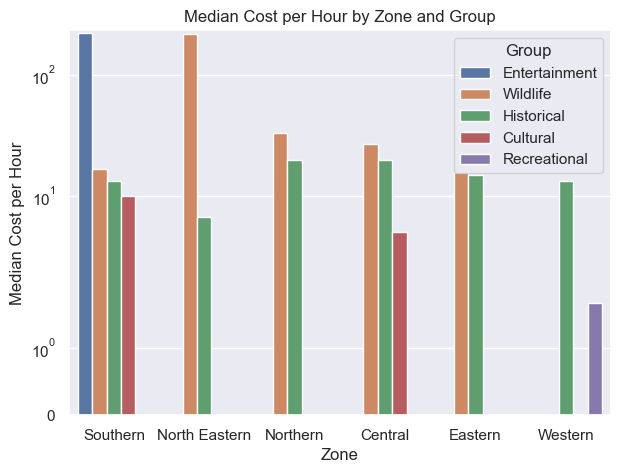

In [428]:
x= 'significance'
y = 'cost_ratio'

temp_df = df

temp_df = temp_df.groupby(['zone',x]).filter(lambda x: len(x) > 2)

temp_df = temp_df.groupby(['zone',x]).median(numeric_only=True).sort_values('cost_ratio', ascending = False)

temp_df = temp_df[temp_df['cost_ratio'] > 0]


plt.figure(figsize=(7, 5))
sns.set_theme(style="darkgrid")
sns.barplot(x="zone", y=y, data=temp_df, errorbar=None, hue = x);
plt.title("Median Cost per Hour by Zone and Group")
plt.xlabel("Zone")
plt.ylabel("Median Cost per Hour")
plt.legend(title="Group")
plt.yscale("symlog")

cost_ratio
significance             
Entertainment  222.500000
Wildlife        25.000000
Historical      17.083333
Cultural        10.000000

<Axes: title={'center': 'Median Cost per Hour by Group'}, xlabel='Median Cost per Hour', ylabel='Group'>

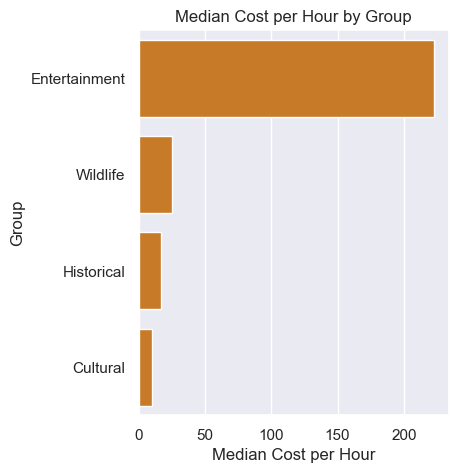

In [430]:
x = 'significance'
y = 'cost_ratio'
temp_df = df[[x,y]].groupby(x, observed = False).filter(lambda x: len(x) > 2)


#temp_df = temp_df.groupby(x, observed = False).median().sort_values('cost_ratio', ascending = False)

#filter = temp_df[['rating']].head().index


#temp_df = df[df[x].isin(filter)]

#temp_df = temp_df.head()

temp_df = temp_df[[x, y]].groupby(x, observed = False).median().sort_values('cost_ratio', ascending = False).head(4)

display(temp_df)
#.mean('cost_ratio').sort_values('cost_ratio', ascending = False).head()



# temp_df = df.groupby('zone')[['cost_ratio']].mean().sort_values('cost_ratio', ascending = False)

# temp_df.reset_index(inplace = True)

# temp_df = df

colors = get_hex('Balistapus_undulatus')
plt.figure(figsize=(4, 5))
sns.set_theme(style="darkgrid")
plt.title("Median Cost per Hour by Group")
plt.xlabel("Median Cost per Hour")
plt.ylabel("Group")
#plt.xscale("log")
sns.barplot(y="significance", x=y, data=temp_df, orient = 'h', color = colors[0])

## Slide 12

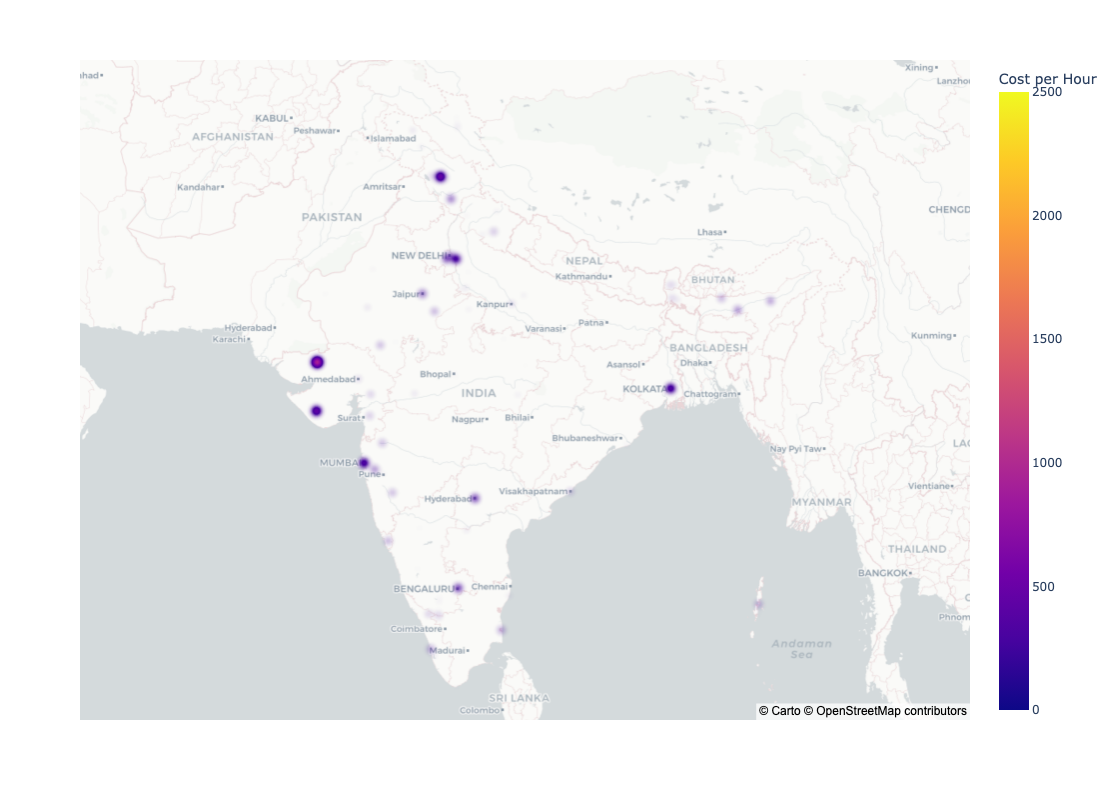

In [432]:
# Create the heatmap

fig = px.density_mapbox(df_geo, lat='lat', lon='lon', z='cost_ratio',
                        radius=10, center=dict(lat=22.5, lon=81),
                        zoom=3.8, mapbox_style="carto-positron", hover_name = 'city', labels={'cost_ratio':'Cost per Hour'})


fig.update_layout(width = 850, height = 800)



fig.show()

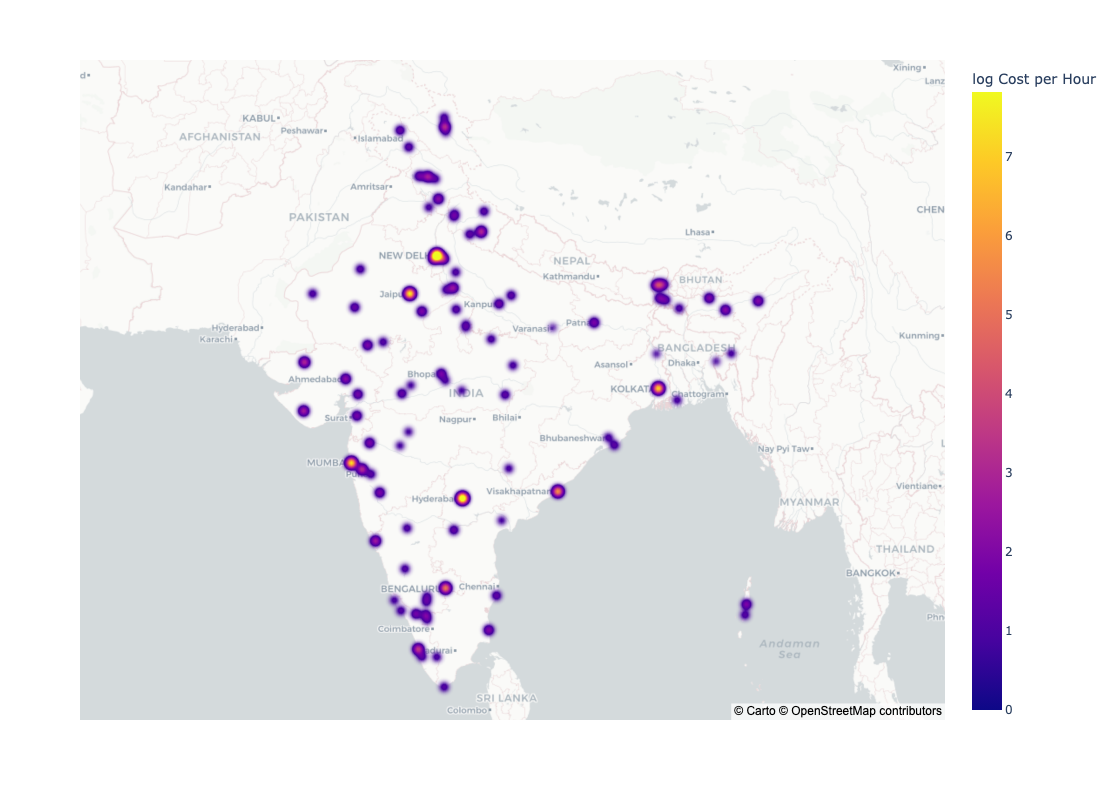

In [434]:
# Create the heatmap

fig = px.density_mapbox(df_geo, lat='lat', lon='lon', z='cost_ratio_log',
                        radius=10, center=dict(lat=22.5, lon=81),
                        zoom=3.8, mapbox_style="carto-positron", hover_name = 'city', labels={'cost_ratio_log':'log Cost per Hour'})


fig.update_layout(width = 850, height = 800)



fig.show()

In [436]:
x = 'med'
temp_df = grid_info_cost_df
temp_df = temp_df[temp_df[[x]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.scatterplot(x=temp_df[x], y=temp_df['pos_count'])

plt.title("Time Required vs. Fee")
plt.xlabel("Median Fee (Rup")
plt.ylabel("Fee (Rupees)")
plt.show()

NameError: name 'grid_info_cost_df' is not defined

## Slide 14

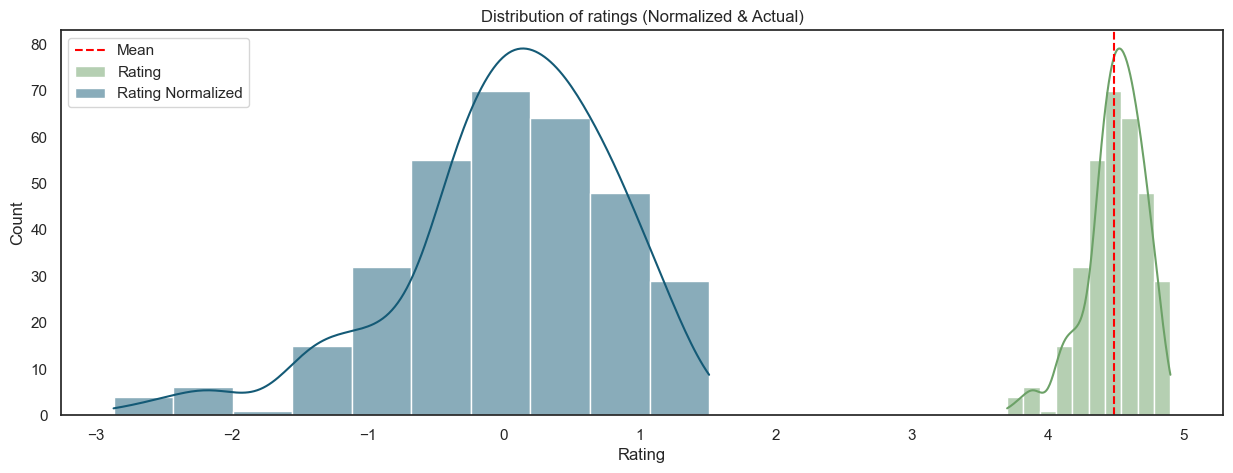

In [438]:
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus') 
plt.figure(figsize=(15, 5))

temp_df = df.loc[df[['rating']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.histplot(data=temp_df, x="rating", bins=10, kde=True, color=colors[2], label ='Rating')

temp_df = df.loc[df[['rating_norm']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.histplot(data=temp_df, x="rating_norm", bins=10, kde=True, color=colors[3], label = 'Rating Normalized')

mean = np.mean(df['rating'])
plt.axvline(mean, color='red', linestyle='--', label='Mean')

plt.legend()
plt.title("Distribution of ratings (Normalized & Actual)")
plt.xlabel("Rating")

plt.show()

## Slide 15

In [440]:
df['year_num'].isna().sum()/df.shape[0]*100

34.46153846153846

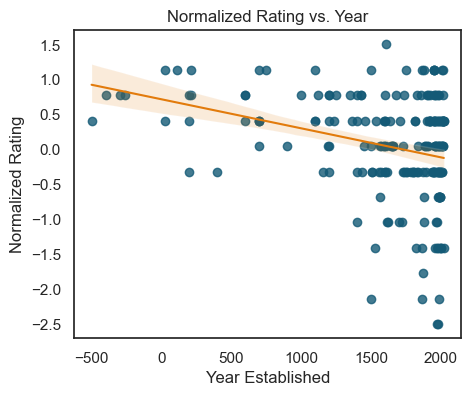

In [442]:
plt.figure(figsize=(5, 4))
x='year_num'
y='rating_norm'
colors = get_hex('Balistapus_undulatus')

temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

sns.regplot(
    x=x,
    y=y,
    data=temp_df, color = colors[3],line_kws={"color": colors[0], "linewidth": 1.5},
).set(title='Normalized Rating vs. Year')

plt.xlabel("Year Established")
plt.ylabel("Normalized Rating")

plt.show()

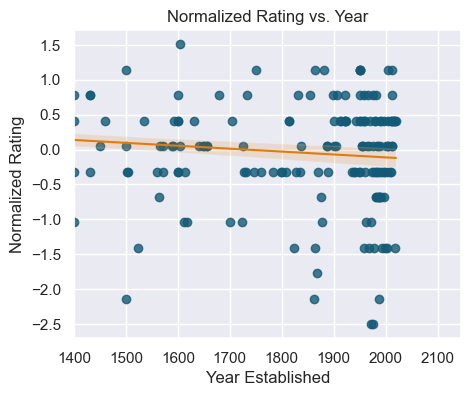

In [444]:
plt.figure(figsize=(5, 4))
sns.set_theme(style="darkgrid")
x='year_num'
y='rating_norm'
colors = get_hex('Balistapus_undulatus')

temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

sns.regplot(
    x=x,
    y=y,
    data=temp_df, color = colors[3],line_kws={"color": colors[0], "linewidth": 1.5},
).set(title='Normalized Rating vs. Year')

plt.xlabel("Year Established")
plt.ylabel("Normalized Rating")
plt.xlim(xmin = 1400)

plt.show()

state
Goa
0


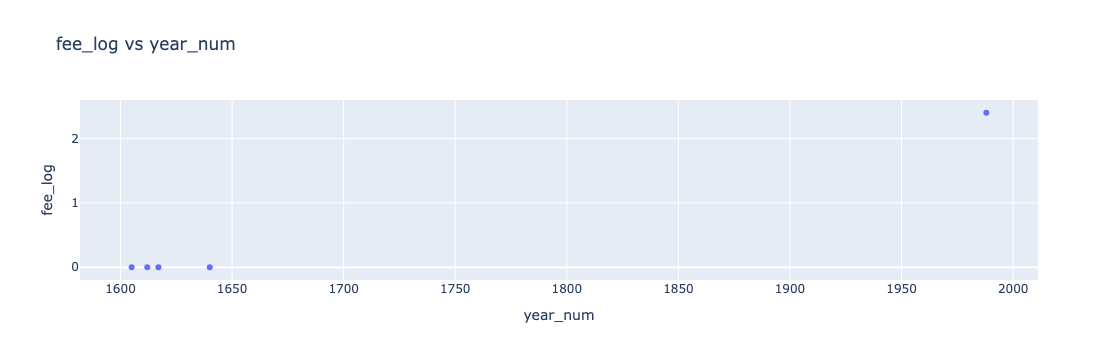

city
Goa
1


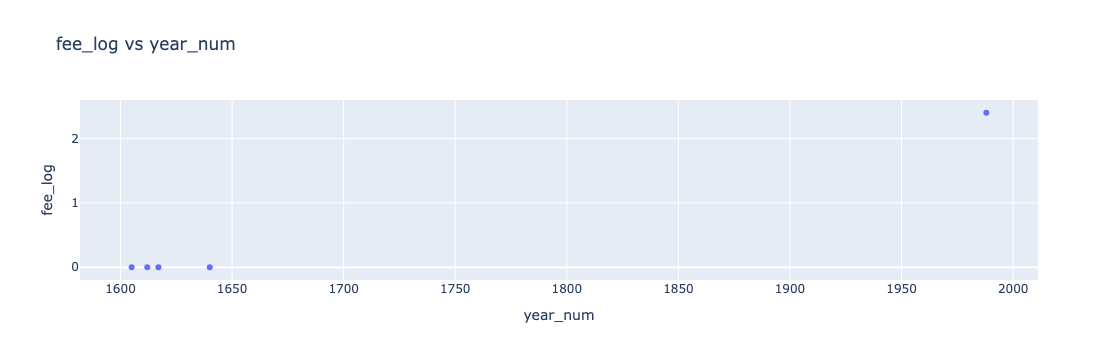

state
Goa
2


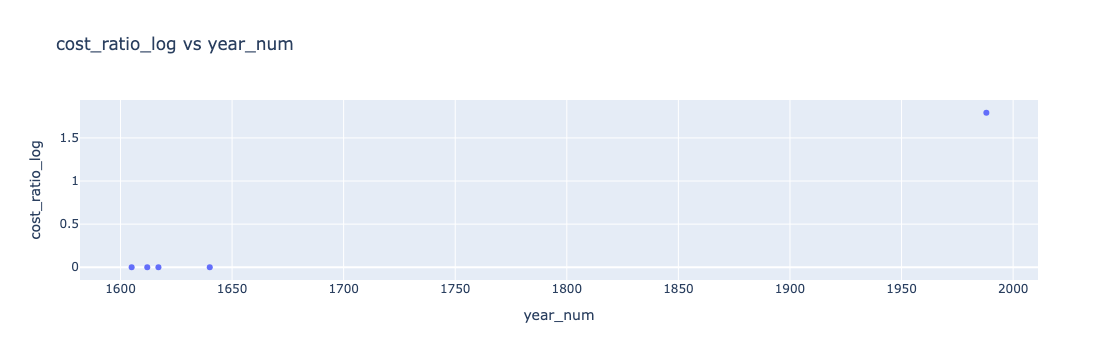

state
Goa
3


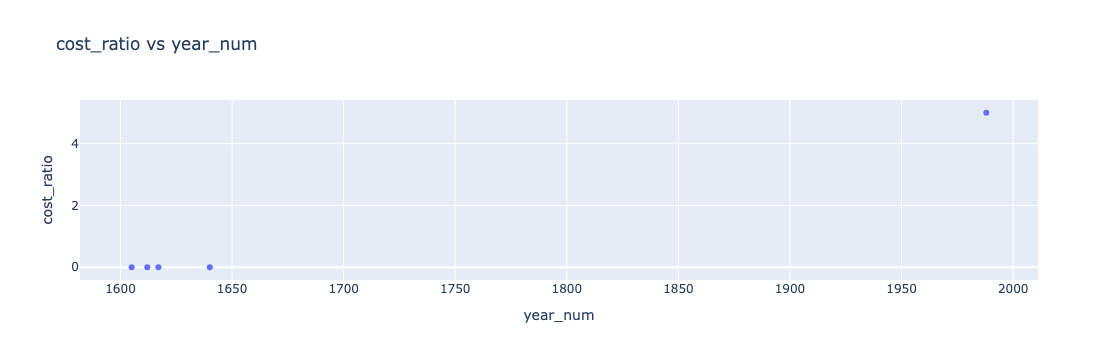

city
Goa
4


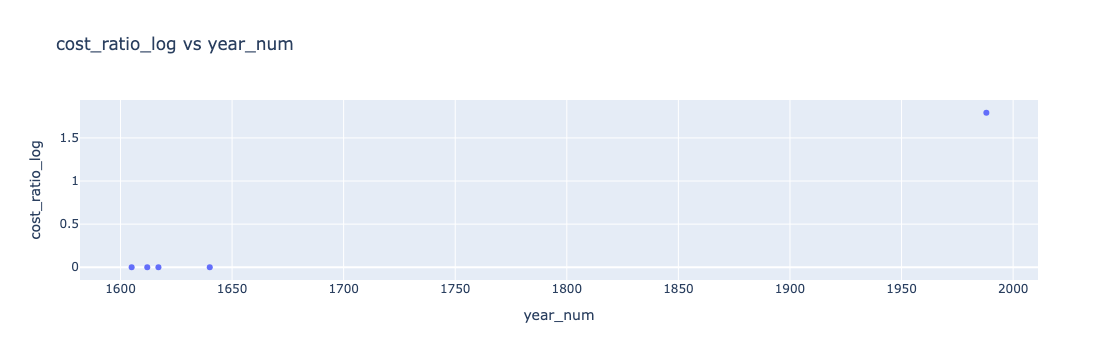

city
Goa
5


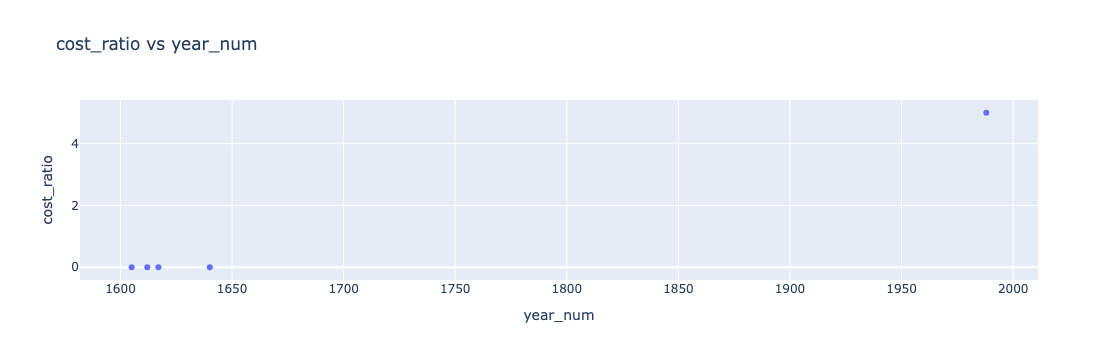

city
Goa
6


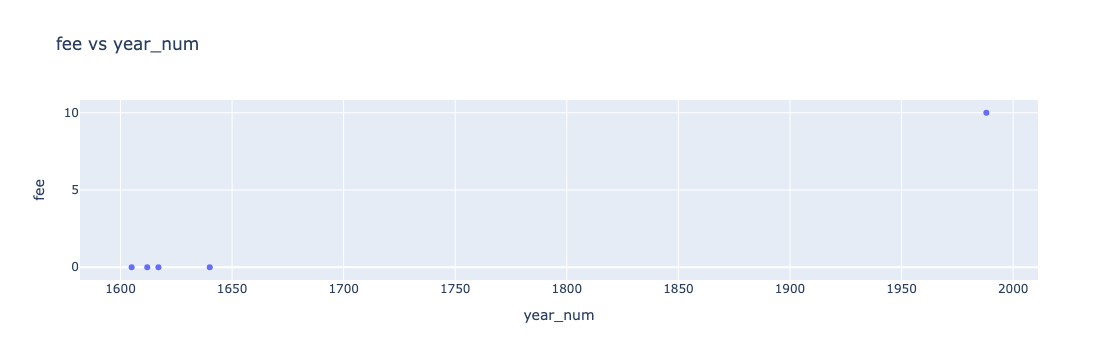

state
Goa
7


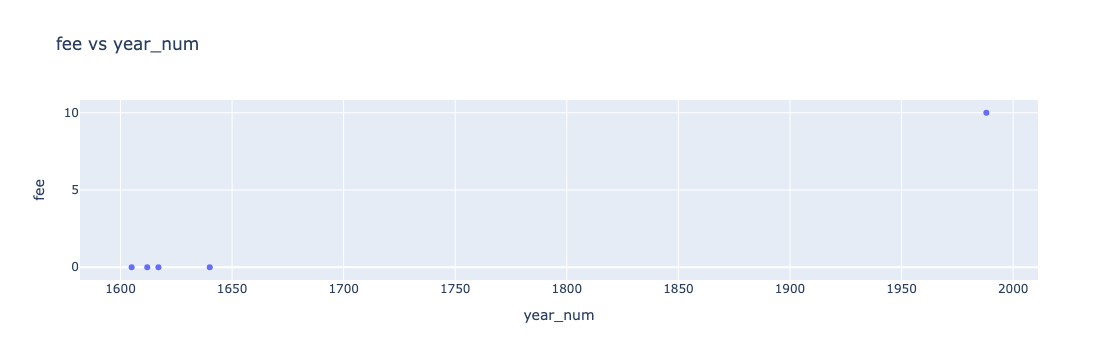

state
Uttar Pradesh
8


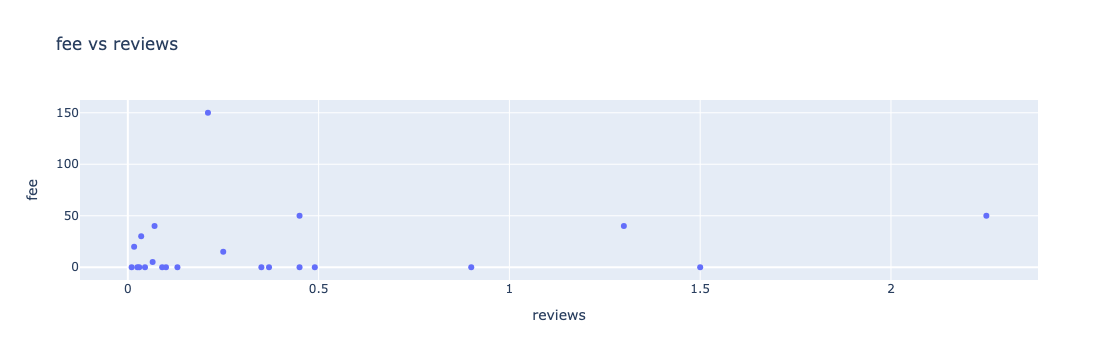

state
Uttar Pradesh
9


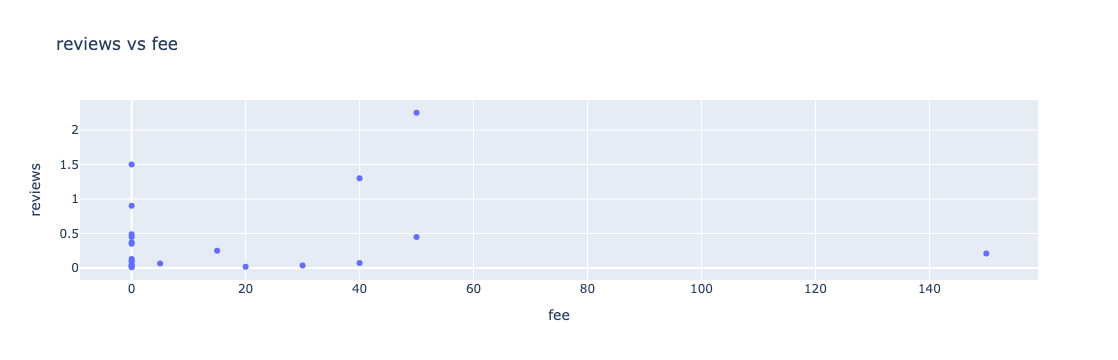

state
Uttar Pradesh
10


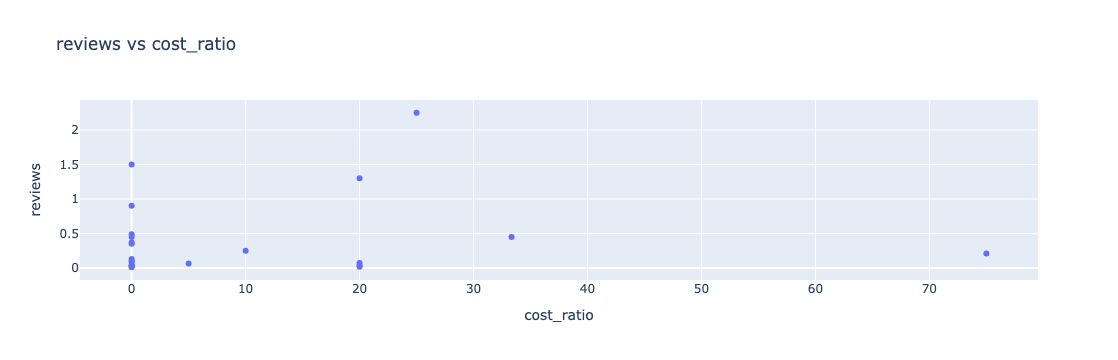

state
Uttar Pradesh
11


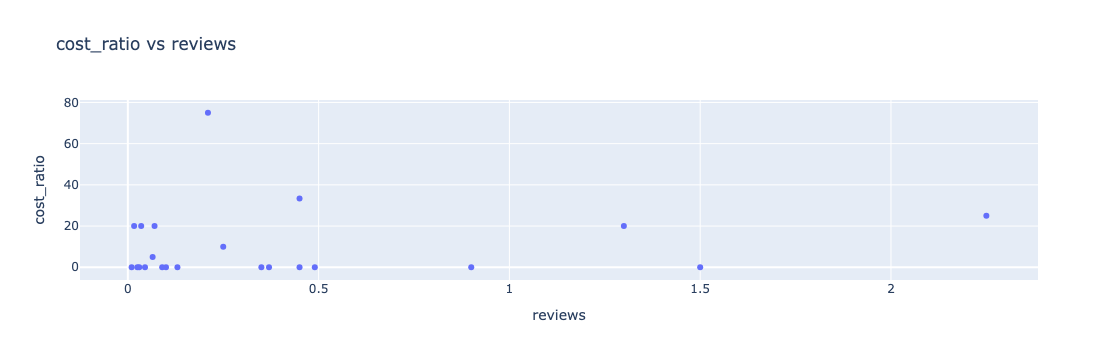

type
Waterfall
12


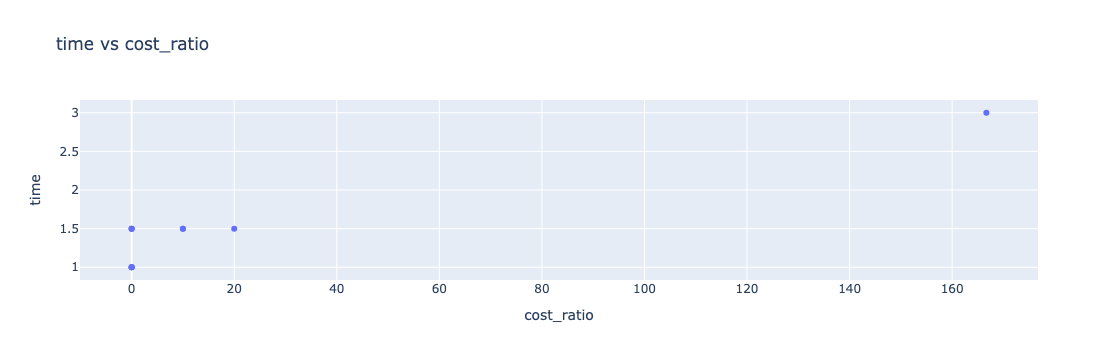

type
Waterfall
13


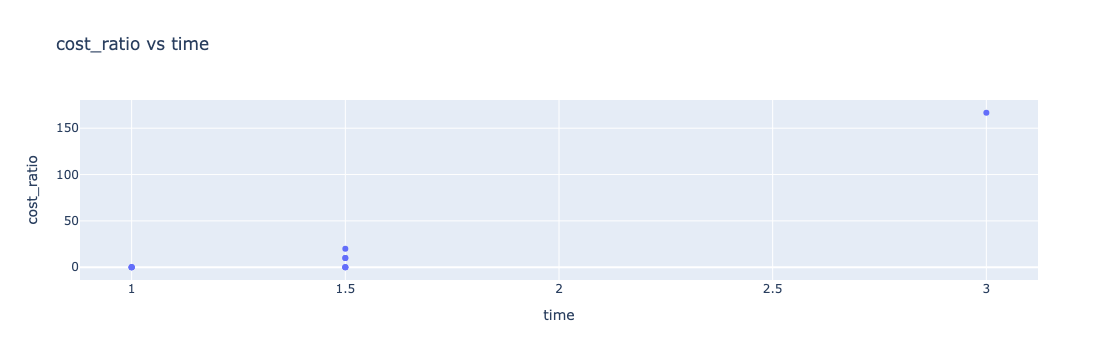

type
Waterfall
14


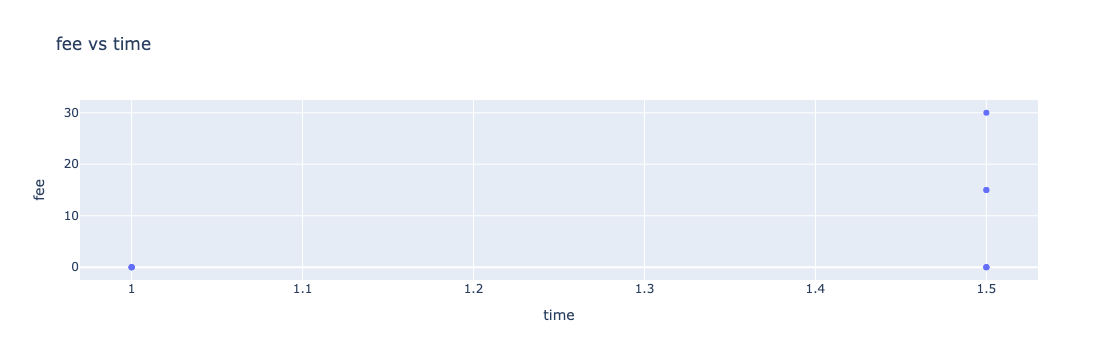

type
Waterfall
15


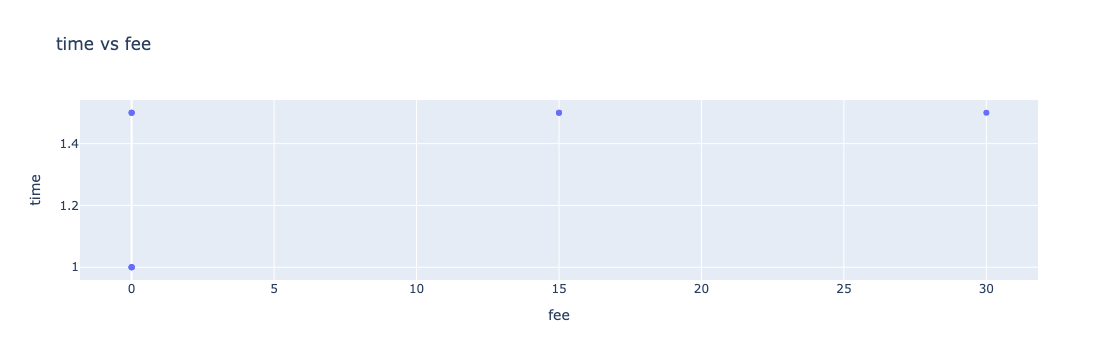

zone
Central
16


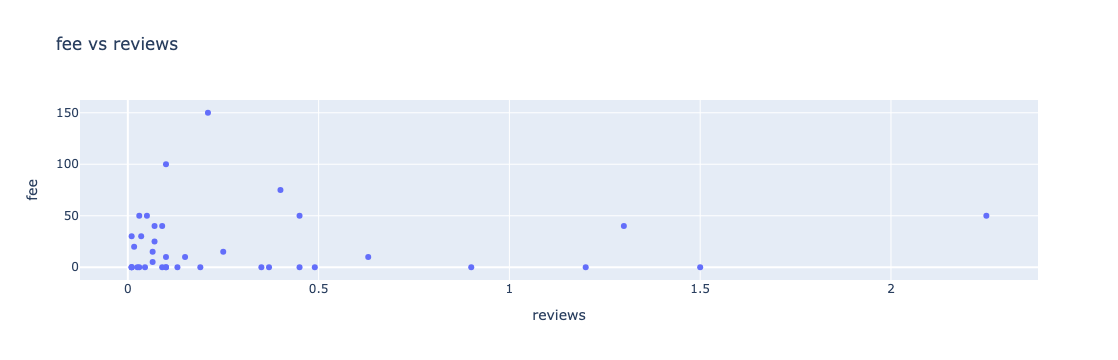

zone
Central
17


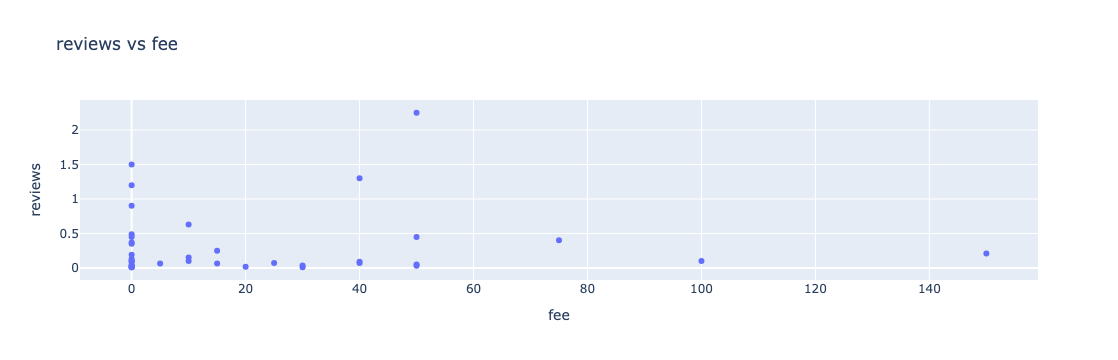

zone
Central
18


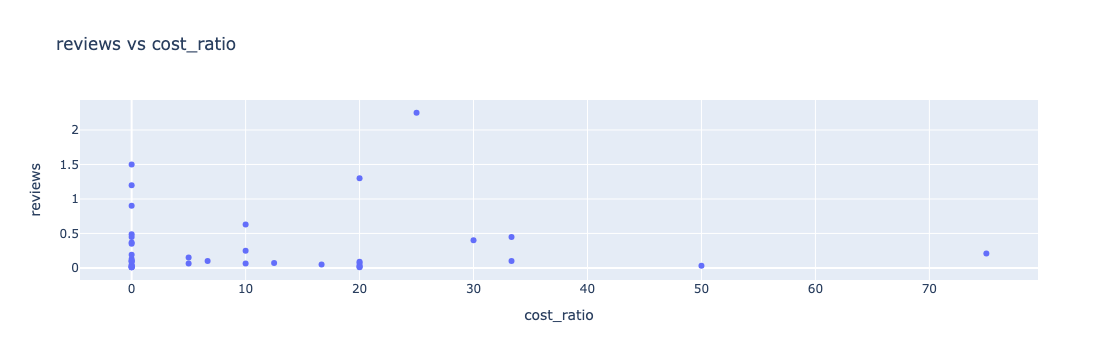

zone
Central
19


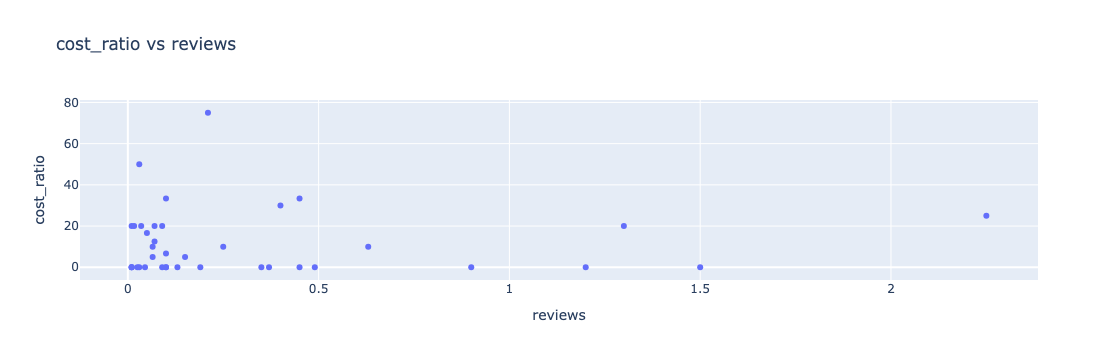

type
Lake
20


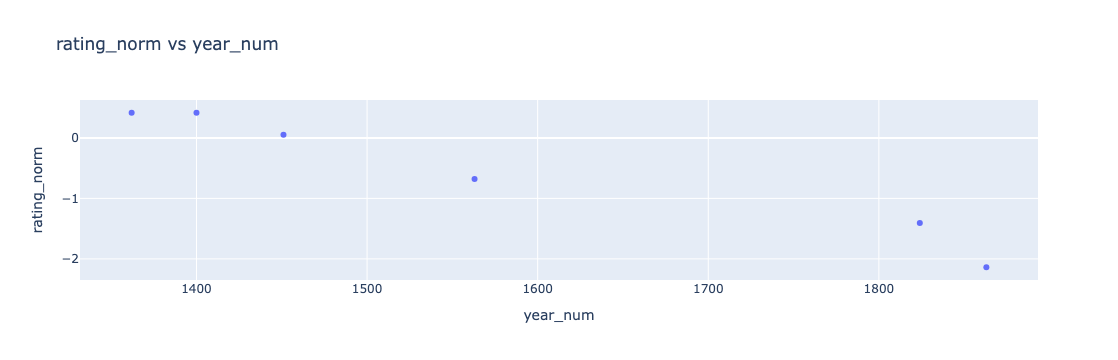

type
Lake
21


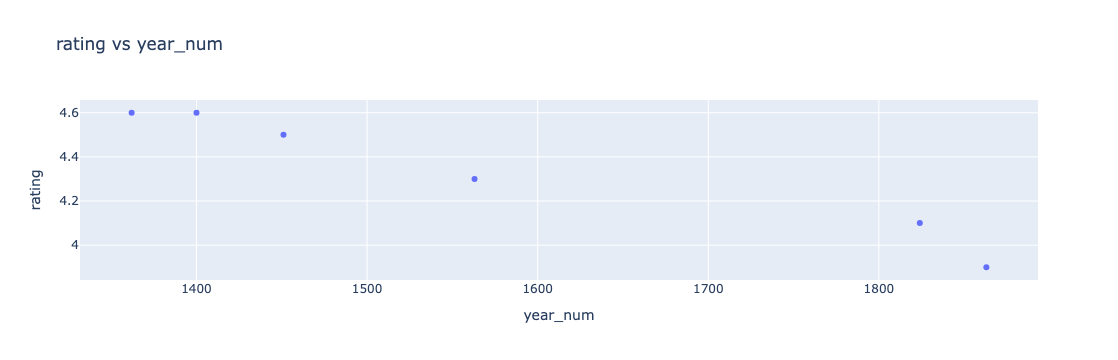

In [454]:
#create filtered correlation table
temp_df = corr_total_f()

#Create scatter plot for each combination of variables in correlation table
for loc in range(0, len(temp_df)):
    var_1, var_2, corr, category, type = temp_df.iloc[loc]
    print(category)
    print(type)
    print(loc)
    display(bivar_sca(var_1, var_2, df = df[df[category] == type]))

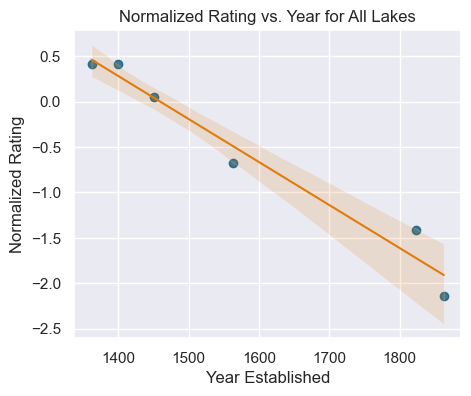

In [456]:
fig, ax = plt.subplots(figsize=(5, 4))
colors = get_hex('Balistapus_undulatus')
x = 'year_num'
y = 'rating_norm'

temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
temp_df= temp_df[temp_df['type'] == 'Lake']

sns.regplot(
    x=temp_df["year_num"],
    y=temp_df["rating_norm"], color = colors[3],
    line_kws={"color": colors[0], "linewidth": 1.5},
    ax=ax,
).set(title='Normalized Rating vs. Year for All Lakes')


plt.xlabel("Year Established")
plt.ylabel("Normalized Rating")
plt.show()


## Slide 16

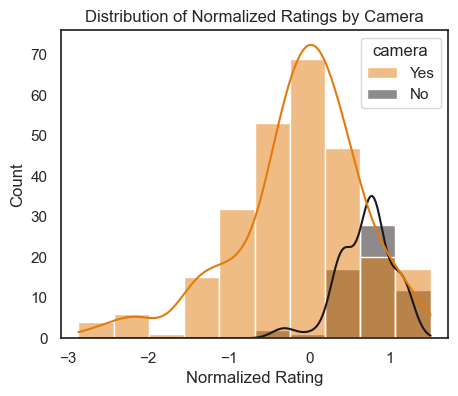

In [458]:
sns.set(rc={'figure.figsize':(5, 4)})
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')


temp_df = df.loc[df[['rating_norm']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.histplot(data=temp_df, x="rating_norm", bins=10, kde=True, hue = 'camera', palette={'Yes': colors[0], 'No': colors[4]})

plt.title("Distribution of Normalized Ratings by Camera")
plt.xlabel("Normalized Rating")

plt.show()

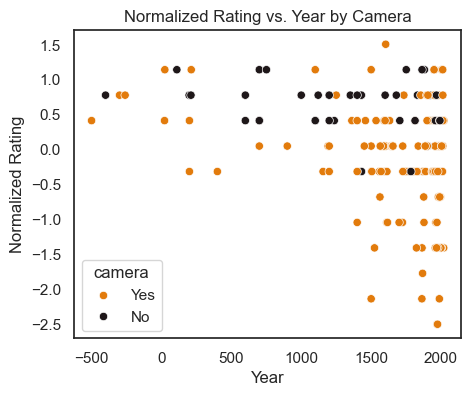

In [460]:
x='year_num'
y='rating_norm'
colors = get_hex('Balistapus_undulatus')

temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.scatterplot(
    x=x,
    y=y,
    data=temp_df,
    hue='camera', palette={'Yes': colors[0], 'No': colors[4]}
)

plt.title("Normalized Rating vs. Year by Camera")
plt.xlabel("Year")
plt.ylabel("Normalized Rating")

plt.show()

## Slide 17

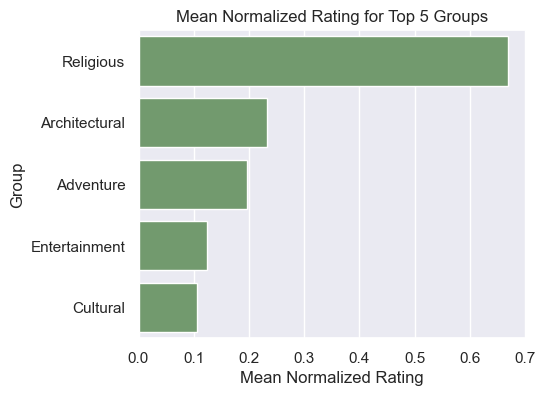

In [462]:
# set plot style: grey grid in the background:
sns.set_theme(style="darkgrid")
x = 'significance'
colors = get_hex('Balistapus_undulatus')
# load dataset

temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x]).mean('rating_norm').sort_values('rating_norm', ascending = False).head(5)

# Set the figure size
plt.figure(figsize=(5, 4))

plt.title("Mean Normalized Rating for Top 5 Groups")
plt.xlabel("Mean Normalized Rating")
plt.ylabel("Group")

# grouped barplot
sns.barplot(y=x, x="rating_norm", data=temp_df, errorbar=None, orient = 'h', color = colors[2]);

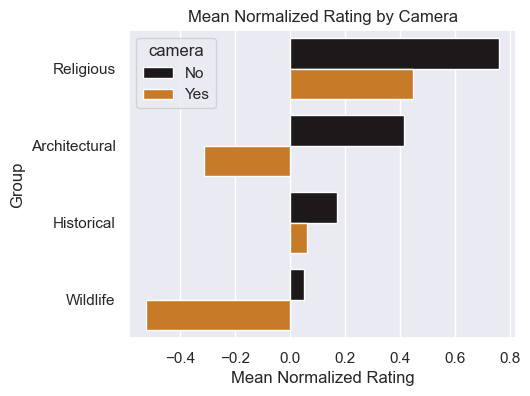

In [464]:
# set plot style: grey grid in the background:
sns.set_theme(style="darkgrid")
x = 'significance'
colors = get_hex('Balistapus_undulatus')

# load dataset

filter_df = df[df['camera'] == 'No']
temp_df = df[df['significance'].isin(filter_df['significance'].unique())]

temp_df = temp_df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x, 'camera']).mean('rating_norm').sort_values('rating_norm', ascending = False)

# Set the figure size
plt.figure(figsize=(5, 4))

plt.title("Mean Normalized Rating by Camera")
plt.xlabel("Mean Normalized Rating")
plt.ylabel("Group")

# grouped barplot
sns.barplot(y=x, x="rating_norm", data=temp_df, errorbar=None, orient = 'h', 
            hue = 'camera', palette = {'No':colors[4], 'Yes':colors[0]});

## Slide 18

<Axes: title={'center': 'Mean Normalized Rating by Type'}, xlabel='Mean Normalized Rating', ylabel='Type'>

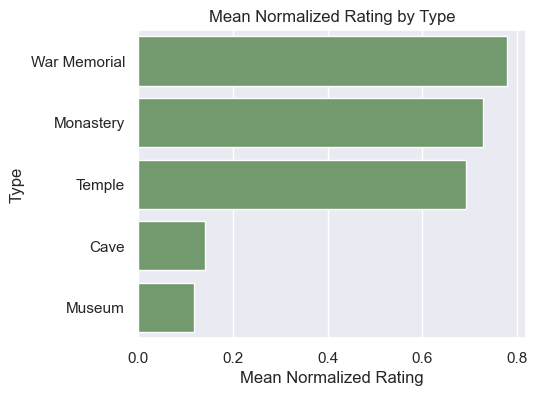

In [466]:
# set plot style: grey grid in the background:
sns.set_theme(style="darkgrid")
colors = get_hex('Balistapus_undulatus')

x = 'type'

temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x]).mean('rating_norm').sort_values('rating_norm', ascending = False).head(5)

# Set the figure size
plt.figure(figsize=(5, 4))

plt.title("Mean Normalized Rating by Type")
plt.xlabel("Mean Normalized Rating")
plt.ylabel("Type")

# grouped barplot
sns.barplot(y=x, x="rating_norm", data=temp_df, errorbar=None, orient = 'h', color = colors[2])

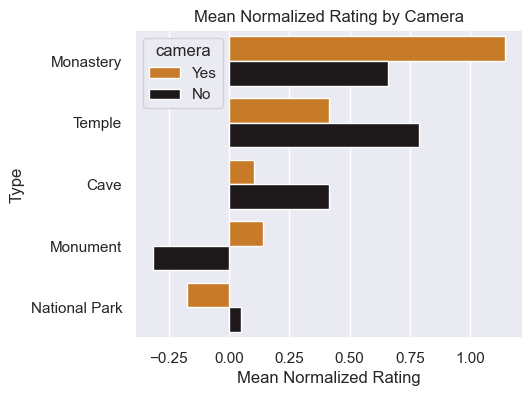

In [468]:
# set plot style: grey grid in the background:
sns.set_theme(style="darkgrid")
colors = get_hex('Balistapus_undulatus')
x = 'type'
# load dataset

filter_df = df[df['camera'] == 'No']
temp_df = df[df[x].isin(filter_df[x].unique())]


temp_df1 = temp_df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x, 'camera']).mean('rating_norm')[['rating_norm']]


temp_df2 = temp_df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x]).mean('rating_norm').sort_values('rating_norm', ascending = False)[['rating_norm']].rename(columns={'rating_norm':'Avg'})

temp_df = temp_df1.join(temp_df2).sort_values('Avg', ascending = False)

# Set the figure size
plt.figure(figsize=(5, 4))

plt.title("Mean Normalized Rating by Camera")
plt.xlabel("Mean Normalized Rating")
plt.ylabel("Type")


# grouped barplot
sns.barplot(y=x, x="rating_norm", data=temp_df, errorbar=None, orient = 'h', 
            hue = 'camera', palette = {'No':colors[4], 'Yes':colors[0]});

In [470]:
temp_df = df[df['camera'] == 'No']

print(temp_df.shape)

print(temp_df[temp_df['type'] == 'Temple'].shape)

temp_df = temp_df[temp_df['rating_norm'] > 0]

print(temp_df.shape)

print(temp_df[temp_df['type'] == 'Cave'].shape)



(60, 25)
(44, 25)
(58, 25)
(1, 25)


## Slide 19

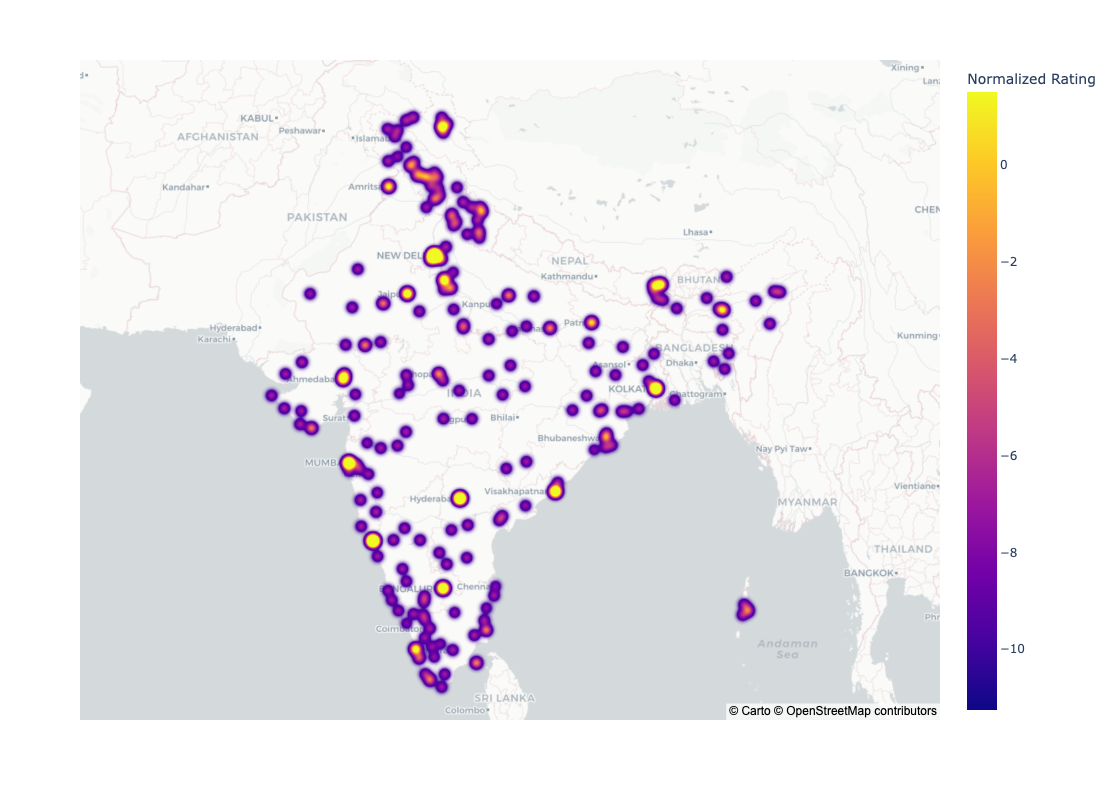

In [472]:
# Create the heatmap

fig = px.density_mapbox(df_geo, lat='lat', lon='lon', z='rating_norm',
                        radius=10, center=dict(lat=22.5, lon=81),
                        zoom=3.8, mapbox_style="carto-positron", hover_name = 'city', labels={'rating_norm':'Normalized Rating'})


fig.update_layout(width = 800, height = 800)

fig.show()

## Slide 20

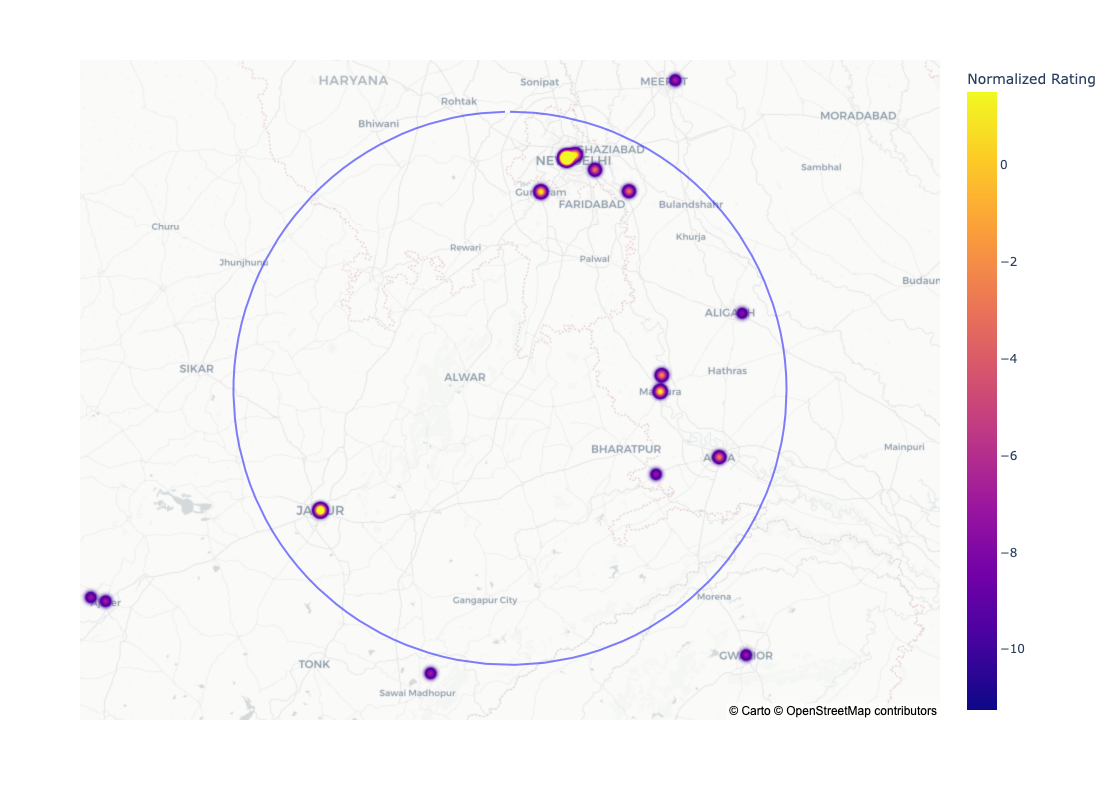

In [482]:
temp_df = df_geo[['city','lat','lon']].drop_duplicates().copy()

x1, y1 = temp_df[temp_df['city'] == 'New Delhi'][['lat','lon']].iloc[0]
x2, y2 = temp_df[temp_df['city'] == 'Agra'][['lat','lon']].iloc[0]
x3, y3 = temp_df[temp_df['city'] == 'Jaipur'][['lat','lon']].iloc[0]

circumcenter_x, circumcenter_y = calculate_circumcenter(x1, y1, x2, y2, x3, y3)



# Create the heatmap

fig = px.density_mapbox(df_geo, lat='lat', lon='lon', z='rating_norm',
                        radius=10, center=dict(lat=circumcenter_x, lon=circumcenter_y),
                        zoom=7, mapbox_style="carto-positron", hover_name = 'city', labels={'rating_norm':'Normalized Rating'})

draw_circle(circumcenter_x, circumcenter_y, 150)

fig.update_layout(width = 810, height = 800)
fig.show()

In [484]:
#Create temporary dataframe with city, latitude and longitude
temp_df = df_geo[['city','lat','lon']].drop_duplicates()

#Store coordinates from New Delhi, Agra, and Jaipur
x1, y1 = temp_df[temp_df['city'] == 'New Delhi'][['lat','lon']].iloc[0]
x2, y2 = temp_df[temp_df['city'] == 'Agra'][['lat','lon']].iloc[0]
x3, y3 = temp_df[temp_df['city'] == 'Jaipur'][['lat','lon']].iloc[0]

#Calculate circumcenter between the cities
circumcenter_x, circumcenter_y = calculate_circumcenter(x1, y1, x2, y2, x3, y3)

# location filter radius in kilometers
r = 150
temp_df = temp_df.dropna()
temp_df = filter_locations(temp_df, circumcenter_x, circumcenter_y, r)

temp_df = df[df['city'].isin(temp_df['city'])]


percent = temp_df[temp_df['rating_norm'] > 0].shape[0]/temp_df.shape[0]
print(f"{percent*100}% of attractions have above average rating")

above_avg = temp_df[temp_df['rating_norm'] > 0].shape[0]
total = temp_df.shape[0]
print(f"{above_avg} out of {total} attractions have above average rating")

norm_avg = temp_df['rating_norm'].mean()
print(f"The average normalized rating is {norm_avg}")

religious_avg = temp_df[temp_df['significance'] == 'Religious']['rating_norm'].mean()
print(f"The average normalized rating for the Religious group is {religious_avg}")


temp_df = temp_df[temp_df['significance'] == 'Religious'].sort_values('rating', ascending = False)

temp_df = temp_df.head()[['name']].rename(columns={'name':'Delhi'})

temp_df = temp_df.reset_index(drop = True)

delhi_top_df = temp_df

delhi_top_df

60.0% of attractions have above average rating
24 out of 40 attractions have above average rating
The average normalized rating is -0.09539728716419109
The average normalized rating for the Religious group is 0.8321208745918414


Delhi
0          Barsana Mandir
1             Prem Mandir
2     Banke Bihari Temple
3  Gurudwara Bangla Sahib
4     Krishna Janmabhoomi

## Slide 21

In [486]:
def rat_dens(df_lst, color_lst, label_lst):
    x = 'rating_norm'
    plt.figure(figsize=(10, 5))
    sns.set_theme(style="darkgrid")
    

    for df, col, lab in zip(df_lst, color_lst, label_lst):
        
        fig = sns.kdeplot(df, fill=True, color=col, label=lab)
        mean = np.mean(df)
        plt.axvline(mean, color=col, linestyle='--', label=f"{lab} Mean")

        plt.xlim(-3, 3)
        
        plt.xlabel("Normalized Rating")
    
    return fig


In [488]:
temp_df = df_geo[['city','lat','lon']].drop_duplicates()

x1, y1 = temp_df[temp_df['city'] == 'New Delhi'][['lat','lon']].iloc[0]
x2, y2 = temp_df[temp_df['city'] == 'Agra'][['lat','lon']].iloc[0]
x3, y3 = temp_df[temp_df['city'] == 'Jaipur'][['lat','lon']].iloc[0]

circumcenter_x, circumcenter_y = calculate_circumcenter(x1, y1, x2, y2, x3, y3)

# location filter radius in kilometers
r = 150
temp_df = temp_df.dropna()
temp_df = filter_locations(temp_df, circumcenter_x, circumcenter_y, r)

focus_df = df[df['city'].isin(temp_df['city'])]




Text(0.5, 1.0, 'Distribution of Ratings')

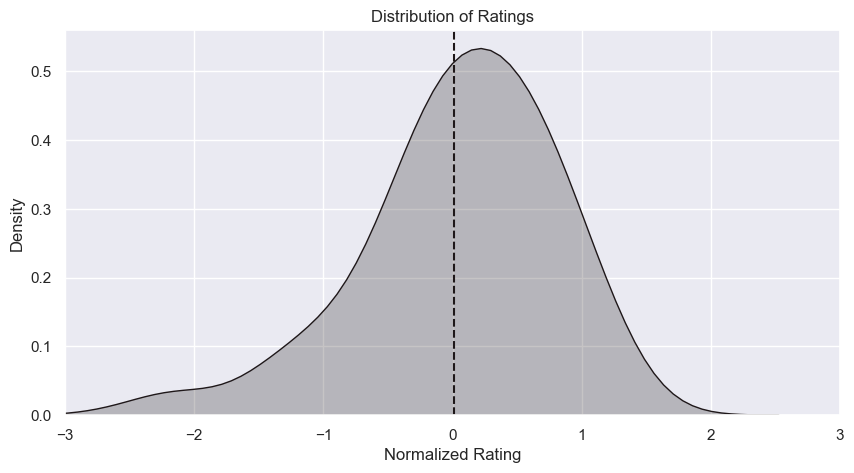

In [490]:
df_lst = [df.groupby(x, observed = False).filter(lambda x: len(x) > 3)['rating_norm']]
color_lst = [colors[4]]
label_lst = ['Overall']
title_lst = 'Distribution of Ratings'

rat_dens(df_lst, color_lst, label_lst)

plt.title("Distribution of Ratings")


Text(0.5, 1.0, 'Distribution of Ratings by Focus Area')

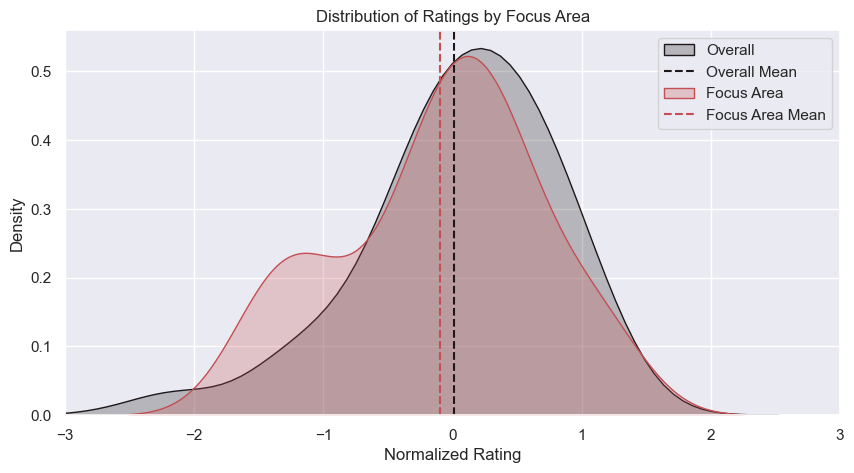

In [492]:
df_lst = [df.groupby(x, observed = False).filter(lambda x: len(x) > 3)['rating_norm'],
         focus_df['rating_norm']]
color_lst = [colors[4],
            'r',
            colors[2]]
label_lst = ['Overall',
            'Focus Area']
title_lst = 'Distribution of Ratings by Focus Area'

rat_dens(df_lst, color_lst, label_lst)
plt.legend() 
plt.title("Distribution of Ratings by Focus Area")

Text(0.5, 1.0, 'Distribution of Ratings')

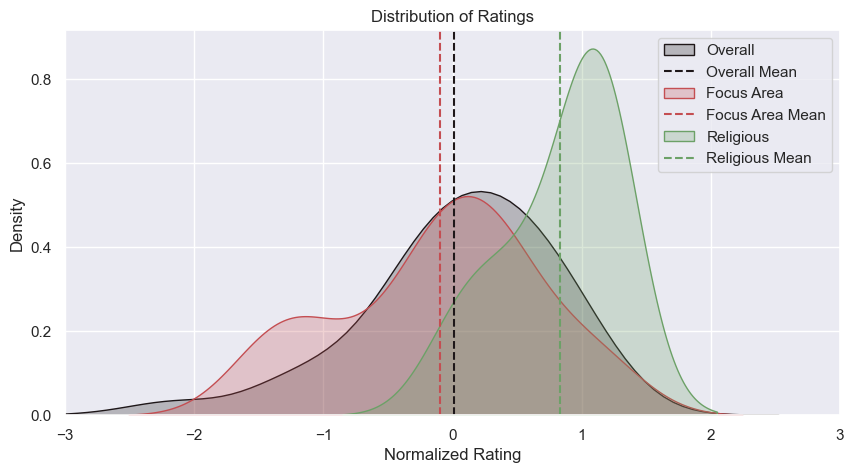

In [494]:
df_lst = [df.groupby(x, observed = False).filter(lambda x: len(x) > 3)['rating_norm'],
         focus_df['rating_norm'],
         focus_df[focus_df['significance'] == 'Religious']['rating_norm']]

color_lst = [colors[4],
            'r',
            colors[2]]

label_lst = ['Overall',
            'Focus Area',
            'Religious']

rat_dens(df_lst, color_lst, label_lst)
plt.legend() 
plt.title("Distribution of Ratings")

## Slide 22

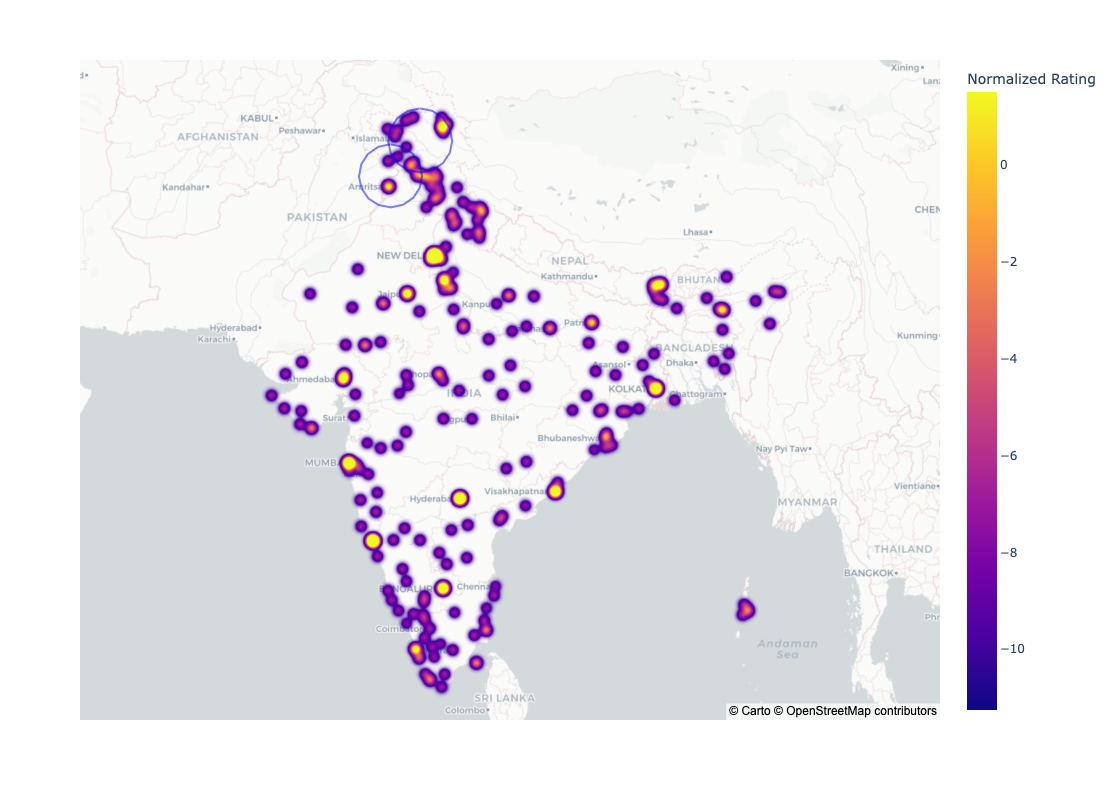

In [496]:
# Create the heatmap

fig = px.density_mapbox(df_geo, lat='lat', lon='lon', z='rating_norm',
                        radius=10, center=dict(lat=22.5, lon=81),
                        zoom=3.8, mapbox_style="carto-positron", hover_name = 'city', labels={'rating_norm':'Normalized Rating'})

fig.update_layout(width = 800, height = 800)
 
temp_df = grid_info_df[grid_info_df['mean'] > 0].copy()

temp_df['dist'] = (temp_df['pos_count'] ** 2 + temp_df['mean'] ** 2) ** 0.5

avg_top = temp_df.sort_values('dist', ascending = False)['mean'].iloc[0]

temp_df = temp_df[temp_df['mean'] >= avg_top].sort_values('dist', ascending = False)

lat1, lon1 = temp_df.head(2)[['lat','lon']].iloc[0]
lat2, lon2 = temp_df.head(2)[['lat','lon']].iloc[1]

draw_circle(lat1, lon1, 150)
draw_circle(lat2, lon2, 150)


fig.show()

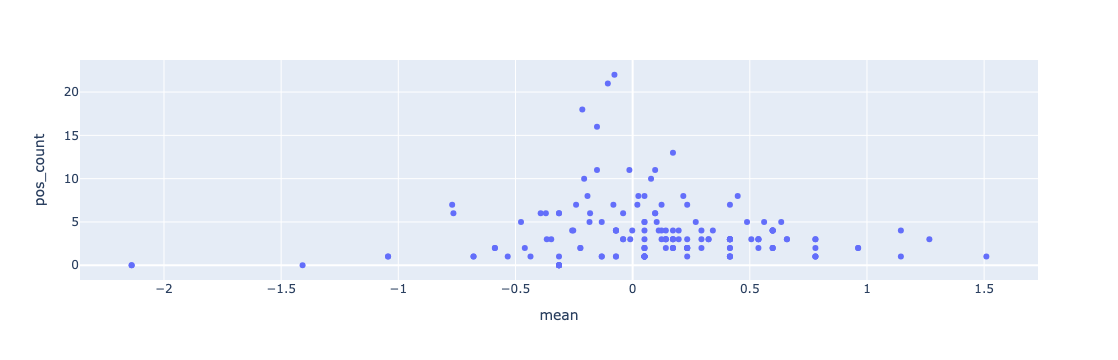

In [498]:
temp_df = grid_info_df

temp_df = temp_df.sort_values('mean', ascending = False)

temp_df

fig = px.scatter(temp_df, x = 'mean', y = 'pos_count', hover_data=['lat','lon'])

fig.show()

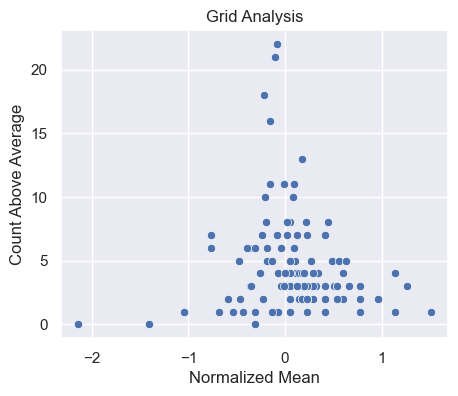

<Figure size 500x400 with 0 Axes>

In [500]:
temp_df = grid_info_df
sns.scatterplot(x=temp_df['mean'], y=temp_df['pos_count'])
plt.title("Grid Analysis")
plt.xlabel("Normalized Mean")
plt.ylabel("Count Above Average")
plt.figure(figsize=(5, 4))
plt.show()

## Slide 23

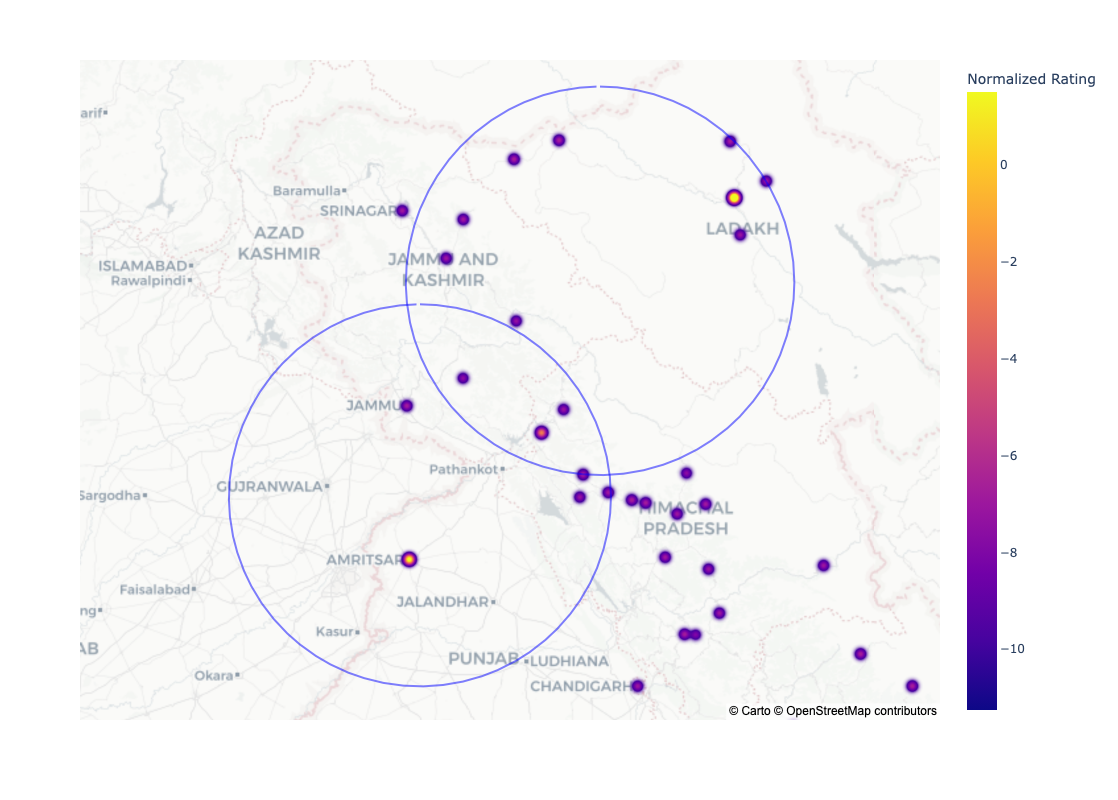

In [502]:
# Create the heatmap
temp_df = grid_info_df[grid_info_df['mean'] > 0].copy()

temp_df['dist'] = (temp_df['pos_count'] ** 2 + temp_df['mean'] ** 2) ** 0.5

avg_top = temp_df.sort_values('dist', ascending = False)['mean'].iloc[0]

temp_df = temp_df[temp_df['mean'] >= avg_top].sort_values('dist', ascending = False)

lat1, lon1 = temp_df.head(2)[['lat','lon']].iloc[0]
lat2, lon2 = temp_df.head(2)[['lat','lon']].iloc[1]

lat = (lat1 + lat2)/2
lon = (lon1 + lon2)/2

fig = px.density_mapbox(df_geo, lat='lat', lon='lon', z='rating_norm',
                        radius=10, center=dict(lat=lat, lon=lon),
                        zoom=6.4, mapbox_style="carto-positron", hover_name = 'city', labels={'rating_norm':'Normalized Rating'})

fig.update_layout(width = 830, height = 800)

draw_circle(lat1, lon1, 150)
draw_circle(lat2, lon2, 150)

fig.show()

## Slide 24

In [514]:
temp_df = grid_info_df[grid_info_df['mean'] > 0].copy()

temp_df['dist'] = (temp_df['pos_count'] ** 2 + temp_df['mean'] ** 2) ** 0.5

avg_top = temp_df.sort_values('dist', ascending = False)['mean'].iloc[0]

temp_df = temp_df[temp_df['mean'] >= avg_top].sort_values('dist', ascending = False)

lat1, lon1 = temp_df.head(2)[['lat','lon']].iloc[0]
lat2, lon2 = temp_df.head(2)[['lat','lon']].iloc[1]

temp_df = df_geo[['city','lat','lon']].drop_duplicates().dropna()

temp_df_1 = filter_locations(temp_df, lat1, lon1, 150)
temp_df_1 = df[df['city'].isin(temp_df_1['city'])]

temp_df_2 = filter_locations(temp_df, lat2, lon2, 150)
temp_df_2 = df[df['city'].isin(temp_df_2['city'])]

alt_df = pd.concat([temp_df_1, temp_df_2])

# abv_avg = temp_df[temp_df['rating_norm'] > 0].shape[0]

# abv_avg_pct = abv_avg / temp_df.shape[0] * 100
# print(f"{abv_avg_pct}% have rating above average")


# temp_df = temp_df[temp_df['rating_norm'] > 0]

print(alt_df['rating_norm'].mean())

print(alt_df[alt_df['significance'] == 'Religious']['rating_norm'].mean())

alt_df.sort_values('rating_norm', ascending = False)


alt_df.groupby('significance')[['rating_norm']].mean().sort_values('rating_norm')

alt_df.groupby('significance').count().sort_values('zone')

alt_df.groupby('significance').filter(lambda x: len(x) > 3).groupby(
    'significance').mean(numeric_only = True)[['rating_norm']].sort_values('rating_norm')


0.27690368748875366
0.6757975889026232


rating_norm
significance             
Recreational    -0.861381
Nature          -0.131873
Religious        0.675798
Historical       0.780013

Text(0.5, 1.0, 'Distribution of Ratings by Focus Area')

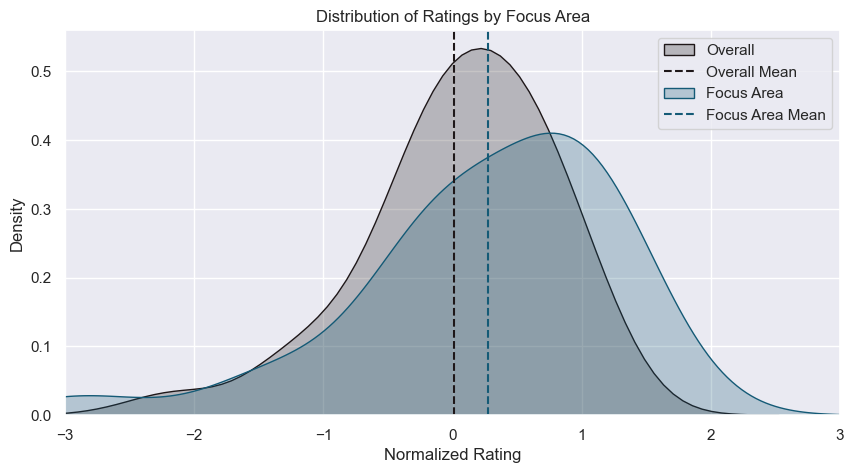

In [518]:
df_lst = [df.groupby(x, observed = False).filter(lambda x: len(x) > 3)['rating_norm'],
         alt_df['rating_norm']]
color_lst = [colors[4],
            colors[3]]
label_lst = ['Overall',
            'Focus Area']
title_lst = 'Distribution of Ratings by Focus Area'

rat_dens(df_lst, color_lst, label_lst)
plt.legend() 
plt.title("Distribution of Ratings by Focus Area")

Text(0.5, 1.0, 'Distribution of Ratings')

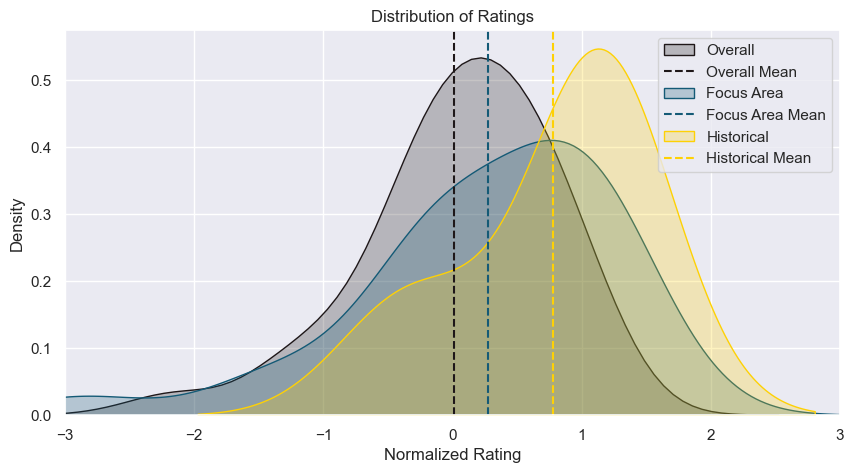

In [520]:
df_lst = [df.groupby(x, observed = False).filter(lambda x: len(x) > 3)['rating_norm'],
         alt_df['rating_norm'],
         alt_df[alt_df['significance'] == 'Historical']['rating_norm']]

color_lst = [colors[4],
            colors[3],
            colors[1]]

label_lst = ['Overall',
            'Focus Area',
            'Historical']

rat_dens(df_lst, color_lst, label_lst)
plt.legend() 
plt.title("Distribution of Ratings")

## Slide 25

In [522]:
top_rec_df = pd.concat([delhi_top_df, north_top_df], axis = 1, ignore_index=False)

top_rec_df.to_csv('top_rec.csv', index = False)
top_rec_df

Delhi                            North
0          Barsana Mandir  Golden Temple (Harmandir Sahib)
1             Prem Mandir                      Pangong Tso
2     Banke Bihari Temple                 Jallianwala Bagh
3  Gurudwara Bangla Sahib                     Wagah Border
4     Krishna Janmabhoomi                Dras War Memorial